# Final Exam Project
## for the class on Collecting and Analyzing Big Data
---
Daria Dementeva - r0771521


Nina Morgenstern - r0772330

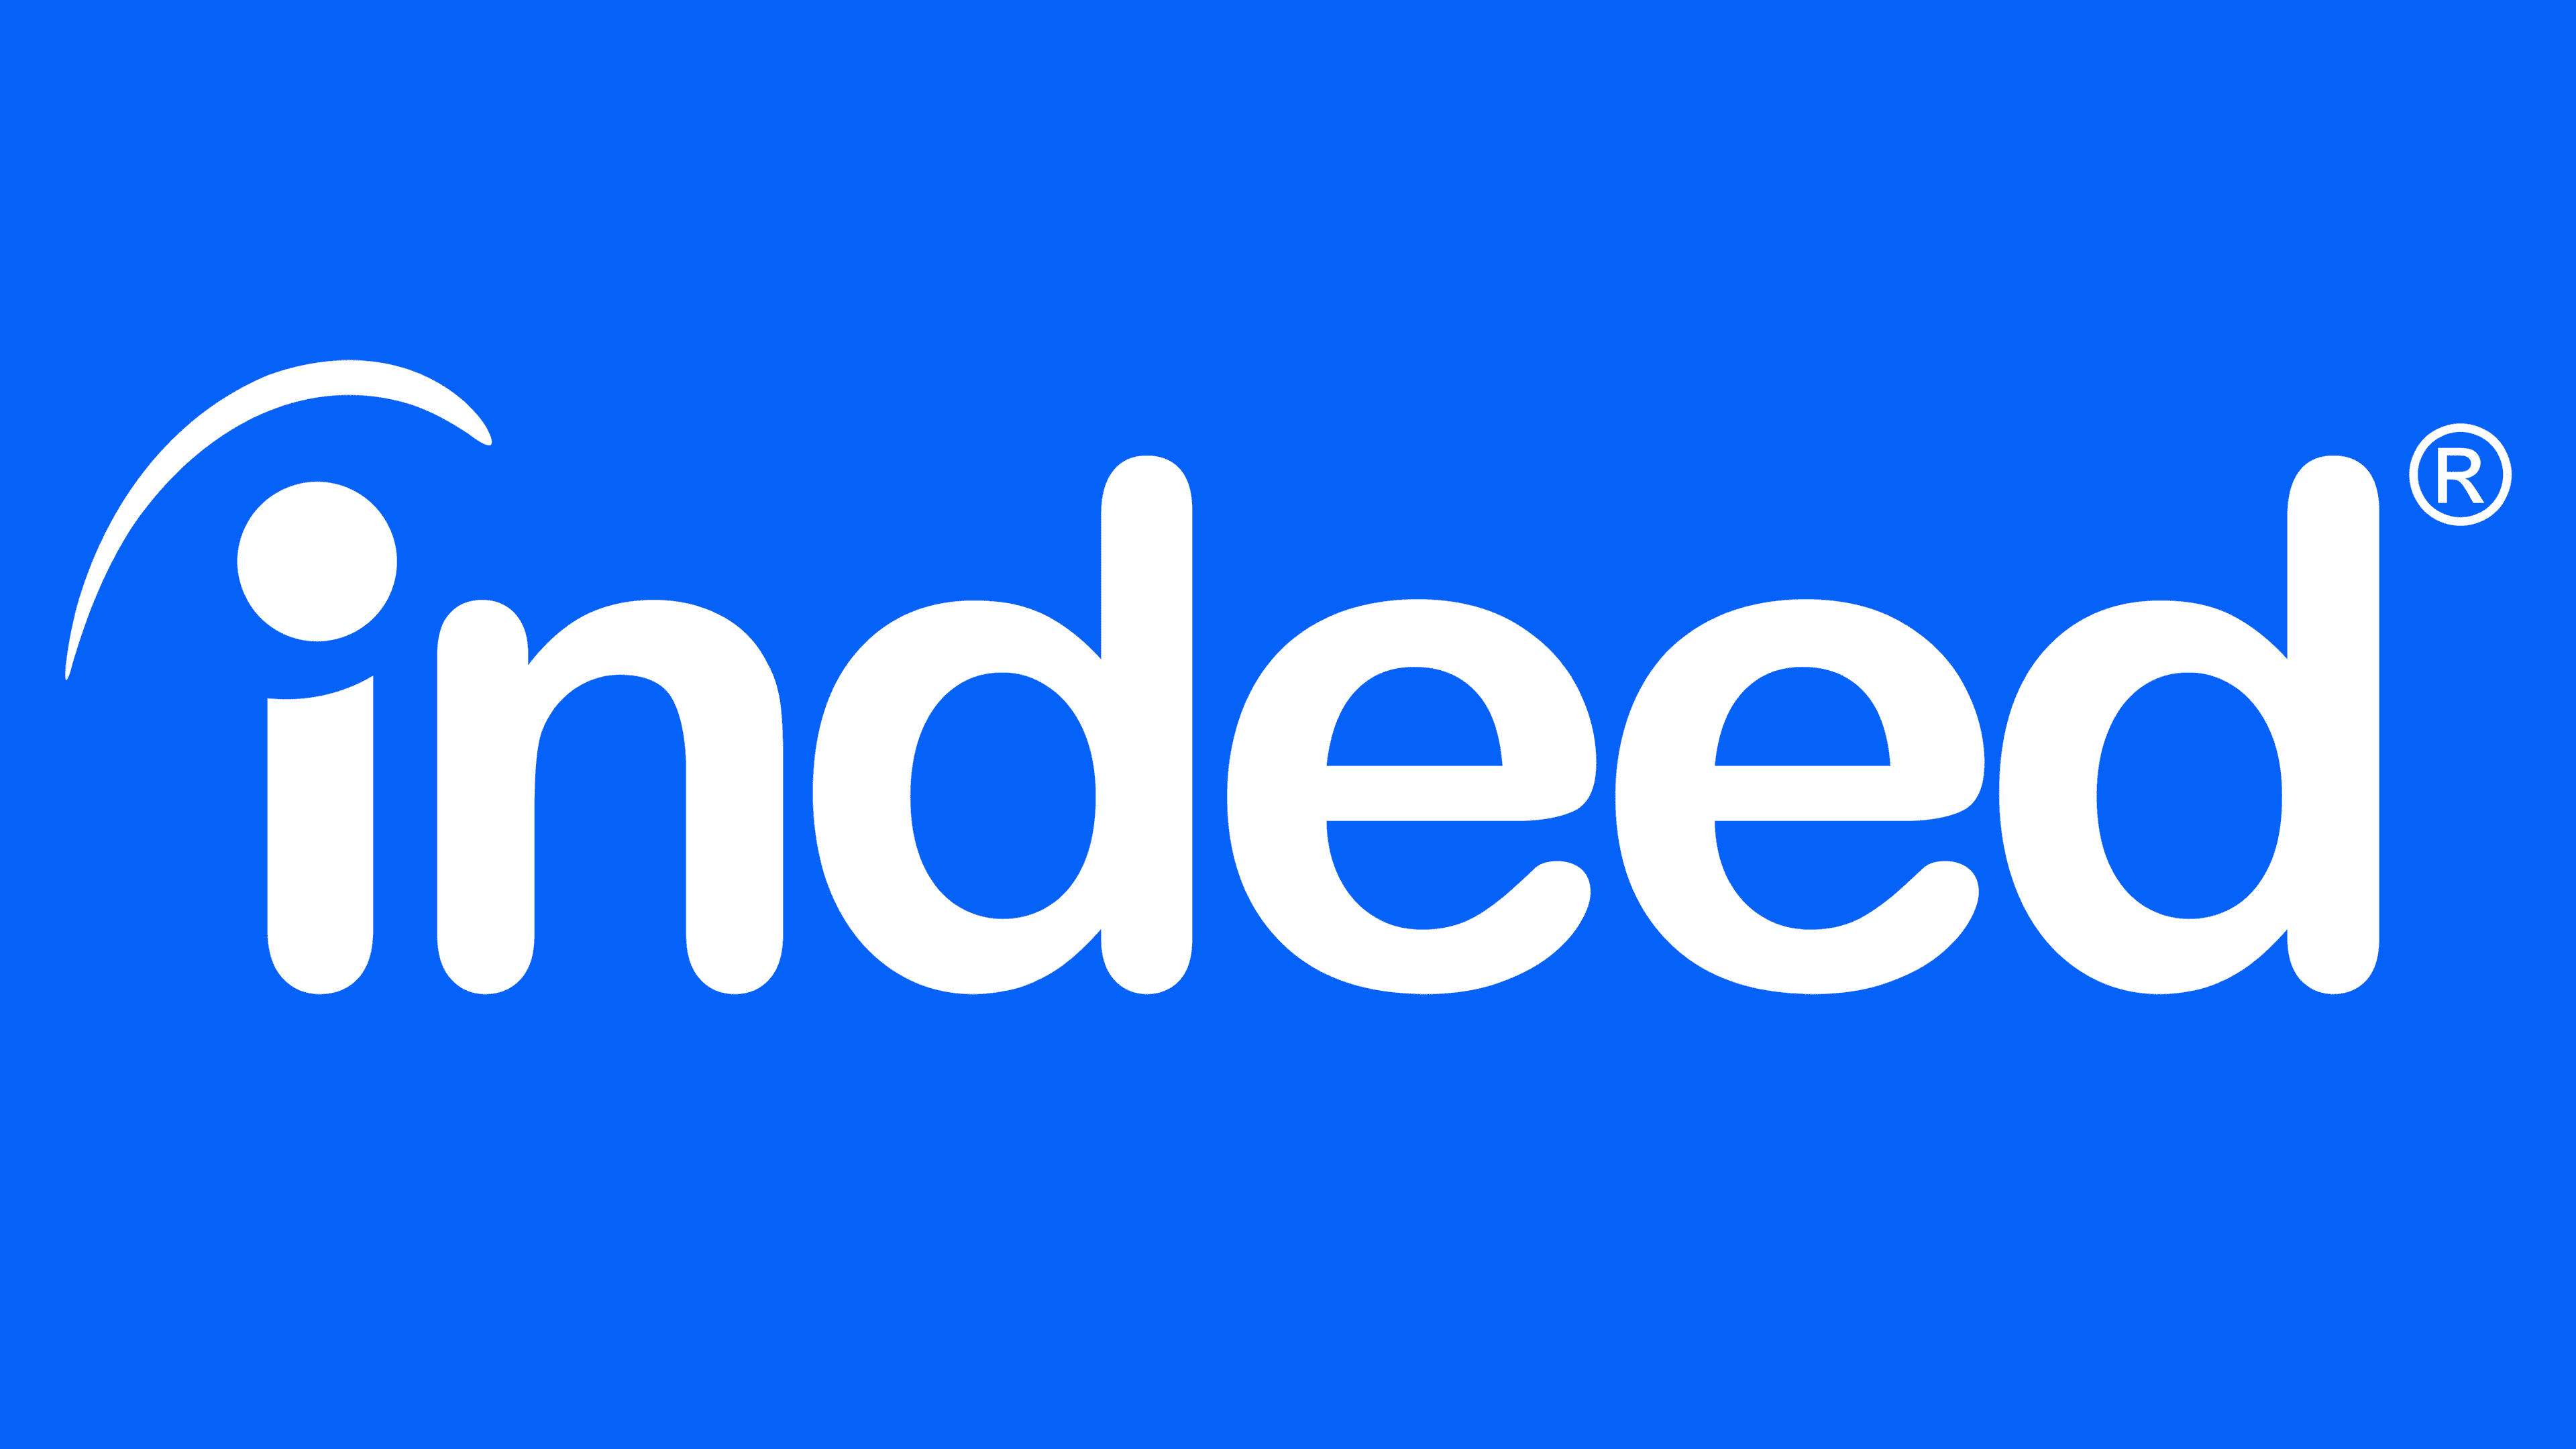

Indeed is one of the biggest websites for job listings and the highest-traffic job website in the United States. As soon-to-be graduates, we spend quite some time on *Indeed.com* looking at jobs after our Master's degree in Statistics and Data Science. Data-related jobs are in demand and *Indeed.com* is full of them. With our analysis, we want to have an insight into the Belgian job market for data-related jobs. 
We intentionally use the term "data-related jobs" instead of "data science" as there is a lack of consensus on its definition in both the academic world and industry (Halwani et al., 2021). For the academic world, it is problematic to develop a study curriculum for future data specialists. At the same time, for industry, it is complicated to introduce job descriptions that match both the labour market requirements and study curriculums of educational organizations (Halwani et al., 2021). Given that, we focus on an overarching umbrella term: "data-related job". We further imply that data-related jobs include business intelligence analysts, data scientists, data analysts, data engineers and machine learning engineers. Our reasoning is in line with that of Halwani et al. (2021), as they similarly operationalized data-related jobs. 

We want to find out what the demanded skills are and what topics appear in data-related job descriptions. We are especially interested in the job descriptions for listings appearing under different search terms. Is there a difference between jobs recommended when searching for data analyst, data scientist, data engineer, machine learning engineer and business intelligence? Since Belgium is a multilingual country, we are interested in which job titles are most often posted in English. Finally, we want to determine if the job description is predictive for the search term under which a job appears.

We proceed as follows. The first step of the analysis is to scrape Indeed to acquire the job descriptions. This poses several challenges as Indeed is not an easy website to scrape. Once we obtain the textual data from the scraping, we preprocess it for our further analyses. As for our methodology, we perform descriptive analysis, including the word frequency distribution and n-grams. Next, we implement topic modelling with the Latent Dirichlet Allocation (LDA) and Top2Vec. Additionally, we will build different multiclass classification models (logistic regression, random forest, support vector machines and multinomial naïve Bayes models, particularly) on the dataset using TF-IDF vectorization as our feature engineering approach. Finally, we summarize our main implications. 

To get a first overview of the job search terms we picked, we look at the Google trends data and plot the relative popularity of our search queries over time (June 2016 until May 2021). The machine learning engineer and data engineer are less popular than the other search terms but gained popularity over time. In 2021 the data analyst is the most popular search term among the queries. Business intelligence has slightly been losing popularity in Google searches since 2020. The data scientist has been gaining in popularity since 2016, but the growth in popularity has stagnated since 2020. Please run the cell below to see the graph.

In [1]:
# Installation on Google Collab only
#!pip install pytrends

# Imports for plotting Google trends
from pytrends.request import TrendReq
import plotly.io as pio
import plotly.express as px
import pandas as pd

# API to get Google search data
pytrends = TrendReq()
pytrends.build_payload(['Data Scientist', 'Data Analyst', 'Data Engineer', 'Machine Learning Engineer', 'Business Intelligence'], timeframe='today 5-y')
df = pytrends.interest_over_time()

# prepare data for plot
df.drop('isPartial', axis=1, inplace=True)
data = pd.melt(df.reset_index(), id_vars='date', var_name = 'search_term', value_name = 'search_volume' )

# plotly 
fig = px.line(data, x="date" , y = "search_volume", color="search_term", line_group = "search_term", labels={"date": "Date", "search_volume": "Search Volume", "search_term": "Search"},
              title="Comparison of Google Searches")
fig.show()

# Imports

In the first step, we import the necessary packages for our anaylsis.

In [ ]:
# Installations for Google Collab only
#!pip install langdetect
#!pip install fake-useragent
#!pip install top2vec
#!pip install category_encoders
#!pip install gensim
#!pip install sklearn

# Basic packages
import re
import math
import time
import numpy as np
import top2vec
import pandas as pd

# Web scraping packages
import requests
from bs4 import BeautifulSoup
from fake_useragent import UserAgent
from langdetect import detect

# NLP packages
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.collocations import *
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import gensim
from gensim import models
import category_encoders as ce

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# ML packages
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from top2vec import Top2Vec
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.utils.fixes import loguniform
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



# Web Scraping

The most challenging step of the analysis is to acquire the data. Since Indeed does not provide an API, we perform web scraping to get the job descriptions for different search terms. We used a trial and error strategy to find the correct selector paths. We define functions to help us with the web scraping process: 
* **get_number_of_iterations**: We inspect the structure of the URL to understand how to send our requests. The job postings stretch over multiple pages, and we need to find out how many pages of postings to scan. We use BeautifulSoup to get the document as a nested data structure. We select the #searchCountPages in our soup to see how many postings there are divided by the limit of postings displayed per page and round this value up. Because we do not want to get banned by the website, we use a random user agent for our requests.

* **get_links**: Function to harvest the link to a job posting from the soup object.

* **visible_texts**: Function to get the description text (body) from the soup and remove unnecessary whitespaces and the javascript code. 

* **get_clean_text**: Create a BeautifulSoup object and apply the visible_texts function

* **detect_language**: Detects the language a job posting is written in. For job postings in Belgium: English, French, Dutch or Unknown.

* **sub_common_strings**: Every job description text starts and ends with the same sentences. This function removes these unnecessary sentences using regular expressions since these sentences are irrelevant for our analysis.



In [ ]:
# Functions

def get_number_of_iterations(query, limit):
    URL = 'https://be.indeed.com/jobs?q=' + query +  '&l=belgium&limit=' + str(limit) + '&filter=' + str(0) + '&start=' + str(0)
    ua = UserAgent()
    header = {'User-Agent':str(ua.random)}
    webpage_request = requests.get(URL, headers = header)
    soup = BeautifulSoup(webpage_request.content, "html.parser")
    replaced_search_count = (soup.select('#searchCountPages')[0].text).replace('.', '')
    iterations = math.ceil(int(re.findall(r"\d+", replaced_search_count)[1])/limit)-1
    return iterations

def get_links(soup):
    links = []
    for link in soup.findAll('a'):
        if (len(re.findall(r"^/pagead/.*", str(link.get('href')))) + len(re.findall(r"^/rc/.*", str(link.get('href')))) > 0):
            links.append(link.get('href'))
    return links

def visible_texts(soup):
    re_spaces = re.compile(r'\s{3,}')
    text = ' '.join([s for s in soup.strings if s.parent.name not in ('style', 'script', 'head', 'title')])
    return re_spaces.sub(' ', text)

def get_clean_text(html):
    soup_temp = BeautifulSoup(html)
    visible_temp = visible_texts(soup_temp)
    return visible_temp
    
def detect_language(cleaned_text):
    lang = 'Unknown'
    try:
        lang = detect(cleaned_text)
    except:
        lang = 'Unknown'
    return lang
    
def sub_common_strings(cleaned_text):
    temp_cleaned_text = re.sub(r"^.*zoeken Geavanceerd zoeken ", "", cleaned_text)
    temp_cleaned_text = re.sub(r"Carrièregids Bladeren door vacatures.*$", "", temp_cleaned_text)
    return temp_cleaned_text

We decided to scrape the job postings for specific search terms. We were interested in the search results for "Business Intelligence", "Data Scientist", "Data Analyst", "Data Engineer", and "Machine Learning Engineer", as we pointed out above. Note that we could not scrape all search terms at once due to internet connection issues and requests coming back empty. We split the scraping, concatenated the data frames and dropped duplicates.

In [ ]:
# search terms
job_categories = ['business+intelligence', 'data+scientist', 'data+analyst', 'data+engineer', 'machine+learning+engineer']

Next, we gather the links to the job postings on Indeed. We use our user-agent and define the **indeed_job_frame**, which will hold our data, including links (Ad_Link) and search term (Job_Category). We set the limit of job postings per page to 50 (the maximum). We loop over the categories and number of pages for each category. We keep track of the category and link by appending them to the meta_link_list and meta_category_list. We use the sleep function with a 10s gap between every request not to overload the website and get banned.
The structure of the URL can be seen below. First, the category (search term) is inserted, then the country (Belgium), the limit of jobs per page (50), the filter (0), and lastly, the page number.


In [ ]:
filter_boolean = 0
limit = 50
ua = UserAgent()

indeed_job_frame = pd.DataFrame({'Job_Category': [], 'Ad_Link': []})

meta_category_list = []
meta_link_list = []

counter = 0
for category in job_categories:
    iterations = get_number_of_iterations(category, limit)
    for page in range(iterations):
        page_num = page*50
        URL = 'https://be.indeed.com/jobs?q=' + category +  '&l=belgium&limit=' + str(limit) + '&filter=' + str(filter_boolean) + '&start=' + str(page_num)
        header = {'User-Agent':str(ua.random)}
        webpage_request = requests.get(URL, headers = header)
        soup = BeautifulSoup(webpage_request.content, "html.parser")
        meta_link_list += get_links(soup)
        for count in range(len(get_links(soup))):
            meta_category_list.append(category)
        counter += 1
        print(category, iterations, counter)
        time.sleep(10)

We insert the **meta_category_list** and the **meta_link_list** as columns to our **indeed_job_frame** and drop and duplicate rows. We see how many jobs posting links from which search term we harvested.

In [ ]:
# append the data frame and drop duplicates
indeed_job_frame['Job_Category'] = meta_category_list
indeed_job_frame['Ad_Link'] = meta_link_list
indeed_job_frame = indeed_job_frame.drop_duplicates()
indeed_job_frame.Job_Category.value_counts()

We use the gathered links to request the HTML data for each job posting. We save each request in the **meta_html_list**, which we append as a new column to the **indeed_job_frame**. We also include the sleep function with a 10s gap between the requests. This makes the processing time consuming, but we are not overwhelming the server with requests.

In [ ]:
# send requests to gathered links
Counter = 0
meta_html_list = []
for indeed_ad in indeed_job_frame.Ad_Link.tolist():
    URL = 'https://be.indeed.com' + str(indeed_ad)
    header = {'User-Agent':str(ua.random)}
    webpage_request = requests.get(URL, headers = header)
    meta_html_list.append(webpage_request.text)
    if (Counter % 100 == 0):
        print(Counter,'Jobs processed')
    Counter += 1
    time.sleep(10)

# append the list to the dataframe    
indeed_job_frame['HTML'] = meta_html_list

Here we apply the cleaning function on the HMTL column to extract the text and use the language detector to label the language a job posting is written in. We drop the HTML column from the data frame and save the results as a CSV file.

In [ ]:
# apply cleaning function
indeed_job_frame['Cleaned_Text'] = indeed_job_frame.HTML.apply(get_clean_text) 

# detect language of job descriptions
indeed_job_frame['Language'] = indeed_job_frame.Cleaned_Text.apply(detect_language)

# remove common strings
indeed_job_frame['Cleaned_Text'] = indeed_job_frame.Cleaned_Text.apply(sub_common_strings)

# drop the HTML column to get a lighter file
indeed_job_frame.drop('HTML',axis=1, inplace=True)

# save as csv for further analysis
indeed_job_frame.to_csv(r'/Users/ninamorgenstern/Desktop/jobs_indeed.csv', index = False)
indeed_job_frame

# Text preparation

Before proceeding to our analyses, we have to pre-process our textual data.  First, we select only the descriptions published in English. Second, the pre-processing is manifold, and it includes:
* Dropping duplicate descriptions;
* Removing descriptions written in an unknown language;
* Removing digits and special symbols;
* Removing HTML tags and URL links;
* Removing stop words.


Third, we lemmatize the descriptions for further analysis. 



The pre-processing of the textual data is an essential step as the web scraped textual data contain a lot of noise that does not have an added value for further analyses. By doing that, we standardize descriptions to facilitate modelling. We read in our textual data. After that, we cross-tabulate each job category with the language of job descriptions.  The first implication is that descriptions in English are dominant across all data-related job categories. Next, descriptions in French are not widespread, while descriptions in Dutch are more common. Likewise, we see that the jobs related to business intelligence and data engineering are the most popular across all languages. It is also the result of web scraping. These two job categories yielded more observations when we scraped *Indeed.com*

In [ ]:
# read in csv file
df = pd.read_csv('jobs_indeed.csv')

# drop possible duplicates
df= df.drop_duplicates()

# remove unknown language
index_names = df[df['Language'] == 'Unknown' ].index
df.drop(index_names, inplace = True)

# replace the '+' sign from the search terms
df['Job_Category'] = df['Job_Category'].str.replace('+',' ')
pd.crosstab(df['Job_Category'], df['Language'])

Language                    en  fr   nl
Job_Category                           
business intelligence      735  46  197
data analyst               363  42  145
data engineer              725  51  456
data scientist             261  30  156
machine learning engineer  219   6   51

Below, we randomly sample descriptions to see what special symbols, characters, and expressions need to be removed. 

In [ ]:
# display some sample descriptions
pd.set_option('display.max_colwidth', 2000)
df.Cleaned_Text.sample(3)

2504    Data Analytics tester (VDAB) Vlaanderen connect. 2 reviews 1000 Brussel Voltijds, Onbepaalde duur Vlaanderen connect. 2 reviews Lees wat andere gebruikers over dit bedrijf te zeggen hebben. Context De Vlaamse Dienst voor Arbeidsbemiddeling en Beroepsopleiding, kortweg VDAB, is een Vlaamse overheidsdienst  die vraag en aanbod op de arbeidsmarkt samenbrengt en vooral als taak heeft werkzoekenden te bemiddelen en te begeleiden naar werk. Zo nodig worden de competenties van de werkzoekenden verhoogd in de competentiecentra van de VDAB. De VDAB is een data gedreven organisatie en moet in 2020 op de kaart staan als de innovatieve netwerkregisseur van de arbeidsmarkt in Vlaanderen! De ICT infrastructuur en de ICT toepassingen dienen de VDAB dienstverlening maximaal te ondersteunen. Zowel de infrastructuur als de toepassingen evolueren permanent. Het is een uitdaging om samen met de business de nieuwe aankomende softwareprojecten uit te werken. De I&T afdeling is een dynamisch team (> 

As we pointed out above, we want to select only the job descriptions written in English. First of all, it will facilitate further analyses as both of us do not speak Dutch and French well. Likewise, we are both internationals looking for English-speaking jobs in Belgium. Once we subset our dataset, we see 2303 job descriptions published in English out of 3889 overall observations. It means that almost 60% of all data-related job postings are published in English, while the other 40% account for either French or Dutch job descriptions. However, it does not necessarily imply that the job description in English requires only the working knowledge of English. It may be the case that decent proficiency in both French and Dutch are solid prerequisites as well. 

In [ ]:
# Number of english job descriptions: 2303 
df_english = df[df["Language"]=="en"].copy()
df_english.shape[0]

2303

Another step of text standardization is to convert all words to lower-case. It helps to reduce the variability of word and letter case noticeably. 

In [ ]:
# Lower case the text
df_english['Cleaned_Text'] = df_english['Cleaned_Text'].str.lower()
df_english.Cleaned_Text.sample(5)

1609    general manager, belgium via brussel as general manager, belgium , you will be responsible for building and fostering a genuine, long-lasting relationship with strategic regional partners and for providing them with guidance on operational, go-to-market, and product strategy. you will be responsible for launching and managing via's largest operational deployment in europe – as well as one of the most ambitious mobility projects worldwide. from building a local operations team to owning the p&l to coordinating among senior stakeholders and operational partners: you will be the one shaping the success of a lighthouse mobility project with far-reaching impact. this gm role requires a combination of intelligence, creativity, and leadership that few possess. this is an opportunity for a truly outstanding project manager and entrepreneur to help build one of via's newest business lines and to shape the future of via in europe. you'll need to be a skilful relationship builder, an oper

Next, we remove all newlines, tabs, and returns to eliminate unnecessary symbols like "\n" and "\t" frequently appearing in job descriptions. Likewise, we all other special symbols like digits, nondigits, white space characters, non–white space characters, HTML tags, URL links, punctuation. Additionally, some meaningless and stand-alone symbol collocations like " mm ", " pp ", " hn ", and unfiltered Dutch expressions like "wat andere gebruikers over dit bedrijf te zeggen", "vacature bedrijf", "solliciteer" are deteled as well. 

In [ ]:
# Elimination of special symbols, characters, collocations and expressions 
# The combinations are adapted from Hovy (2021).

df_english = df_english.replace(r'\r+|\n+|\t+','', regex=True) # remove all new lines, all tabs, all returns
df_english = df_english.replace(r'[\S]+\.(net|com|org|info|edu|gov|uk|de|ca|jp|fr|au|us|ru|ch|it|nel|se|no|es|mil)[\S]*\s?','', regex=True) #remove websites
df_english = df_english.replace(r'[^\w\s]','', regex=True) # remove punctuation
df_english = df_english.replace(r'\d+','', regex=True) # remove digits 
df_english = df_english.replace(r'review','', regex=True) # remove the word "review"
df_english = df_english.replace(r'reviews','', regex=True) # remove the word "reviews"
df_english = df_english.replace(r'  s ','', regex=True) # remove "  s " symbol
df_english = df_english.replace(r' mm ','', regex=True) # remove "mm" symbol
df_english = df_english.replace(r' pp ','', regex=True) # remove "pp" symbol
df_english = df_english.replace(r' bb ','', regex=True) # remove "bb" symbol
df_english = df_english.replace(r' q ','', regex=True) # remove "q" symbol
df_english = df_english.replace(r' hn ','', regex=True) # remove "hn" symbol
df_english = df_english.replace(r'httpwwwsosvillagesenfantsbe','', regex=True) # remove "hn" symbol

# remove some Dutch words and phrases

df_english = df_english.replace(r'wat andere gebruikers over dit bedrijf te zeggen','', regex=True)
df_english = df_english.replace(r'vacature bedrijf','', regex=True)
df_english = df_english.replace(r'deze vacature is verlopen op indd mogelijke redenen zijn de werkgever acceptrt momentl gn sollicitaties is niet actief op zoek naar nieuwe medewerkers of is bezig met het beoordelen van sollicitaties','', regex=True)
df_english = df_english.replace(r'bij','', regex=True)
df_english = df_english.replace(r'solliciteer','', regex=True)
df_english = df_english.replace(r'opslaan','', regex=True)
df_english = df_english.replace(r'bijwerkgever','', regex=True)

# check the tidiness of our textual data

df_english.Cleaned_Text.sample(3)

2498    data scientist proximus groupbrussel proximus grouplees  hebben  we open up a world of digital opportunities so people live better and work smarter job content you will be part of the advanced analytics center of expertise a centralized team of data scientists that is supporting the different business units within proximus you will transform data into actionable insights that drive operational processes or influence strategic decisions use cases can be companywide covering domains such as predictive maintenance network analytics operational efficiency customer relationship management image recognition and natural language processing responsibilities translate business requests into data requirements extract the required structured and unstructured data from the proximus data lake data warehouse and other data sources eg operational systems and prepare largescale datasets for modelling identify highvalue use cases through data exploration and visualization develop predictive mod

As it usually turns out, some words often occur in textual data but do not contribute to the analysis and are senseless to utilize. The set of these words is called stopwords (Hovy, 2021). They include determiners, prepositions, pronouns, conjunctions etc. 


Next, we lemmatize the descriptions as we are more interested in the meaning than morphology or syntax (Hovy, 2021).  Lemmatization reduces variability in the textual data and makes it easier to proceed with further statistical analyses. We introduce a stand-alone function to remove stopwords for English and lemmatize the text simultaneously. For this, we use the NLTK package. It has a robust lemmatization function, "WordNetLemmatizer", that treats syntax of words and semantics like speech (Sarkar, 2019)



In [ ]:
# define function for stop word removal and lemmatization
lemmatizer = WordNetLemmatizer()  
stop_words = set(stopwords.words('english'))

def stopwords_lemmatization(document):
  document = " ".join([w for w in document.split(" ") if not w.lower() in stop_words])
  words = nltk.word_tokenize(document)
  text = ""
  for word in words:
    text += " " + lemmatizer.lemmatize(word)
  return text


Below, we apply our function to our description. We check the result by sampling some descriptions from the corpus at random.

In [ ]:
# apply stopwords_lemmatization
df_english["Cleaned_Text"] = df_english.Cleaned_Text.apply(stopwords_lemmatization)
df_english.Cleaned_Text.sample(3)

2762                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                data bi analyst sparagus brussel looking databi analyst help u increasing workload client rapidly growing data farm pharmaceutical data belgium managing endtoend data lifecycle ingestion data sciencemachine learning data visualisation predictive analytics within data warehouse environment employee experience broad culture collaborative work area data management growing core responsibility foster environment deep learning every part engineering processing accessibl

# Descriptive Analysis
We conduct preliminary descriptive analysis to explore our textual data and get an idea of what words and word collocations are the most frequent. To do so, we demonstrate a word frequency distribution. In addition to individual words that appeared in the word frequency distribution, we show n-grams (the sequences of tokens) of lengths 2 and 3 (referred to as bigrams and trigrams) to identify the most important word collocations used for data-related job postings (Novy, 2021). 



## Word Frequency Distribution

To visualize our word frequency distribution, we first tokenize the descriptions. To obtain the word frequency distribution, we use the function "FreqDist" from the NLTK package. Then we print 30 most frequent words.

In [ ]:
# tokenize the text
tokenized_word=word_tokenize(str(df_english["Cleaned_Text"]))

In [ ]:
# get the frequency distribution
fdist = FreqDist(tokenized_word)
print(fdist)

<FreqDist with 1042 samples and 2467 outcomes>


In [ ]:
# print the 30 most common words
fdist.most_common(30)

[('data', 134),
 ('team', 30),
 ('experience', 27),
 ('engineer', 26),
 ('business', 24),
 ('platform', 21),
 ('solution', 21),
 ('customer', 19),
 ('work', 18),
 ('science', 16),
 ('technology', 16),
 ('knowledge', 15),
 ('working', 15),
 ('service', 15),
 ('project', 14),
 ('support', 14),
 ('engineering', 14),
 ('research', 13),
 ('product', 13),
 ('new', 13),
 ('cloud', 13),
 ('big', 13),
 ('environment', 12),
 ('requirement', 12),
 ('aws', 12),
 ('iot', 12),
 ('implement', 11),
 ('use', 11),
 ('company', 10),
 ('skill', 10)]

Our implications are as follows. The most frequent word is "data". This is obvious as the job description are data-related. The following frequent word is "team". It is, in general, in line with the requirements for data scientists, data analysts, data engineers etc. Typically, data-related tasks and projects are processed in teams. We may imply that data-related jobs are connected with extensive teamwork. Another plausible interpretation is that working requires being involved in a team of colleagues and partners, in general.  The next popular word is experience.  As data-related tasks and projects require a great deal of problem-solving skills, it means that an application should have some prior experience in manipulating problem-specific datasets and building statistical models. However, this might be sketchy evidence in favour of so-called the "Permission Paradox".  The "Permission Paradox" refers to the situation when someone cannot get a proper job without experience, but someone cannot get experience without a job (No Work Experience? Here's How To Overcome The Permission Paradox And Get Hired, 2019). The "Permission Paradox" might also be related to the general graduate unemployment in the situation of qualified labour force shortage. Highly educated graduates in data science, statistics, data engineering and business analytics, are expected to find a job without any obstacle. However, otherwise frequently happens.
Other frequent words are "solution', "science",  "technology",  "knowledge", "research". It can serve as evidence that data-related jobs are still embedded into research-related and science-oriented context. 
The figure below shows the word frequency distribution.

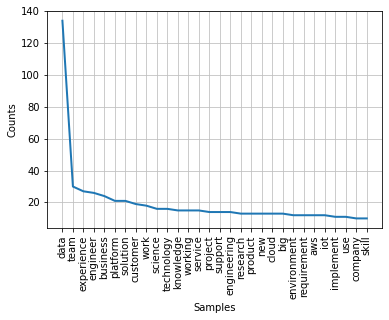

In [ ]:
# plot the frequency distribution of the 30 most common words
fdist.plot(30,cumulative=False)
plt.show()

## n-grams: Collocations

Next, we find bigram word collocations using the function "BigramCollocationFinder" from the NLTK package. We show the 30 most frequent bigrams below. Implicitly, we notice various bigrams categories. For example, bigrams such as ('communication', 'skill'), ('close', 'collaboration'), ('team, player'), ('customer', 'service') may refer to a general set of soft skills data-related jobs require for internal and external communication. Next, bigrams such as ('ai', 'engineer'), ('big', 'data'), ('computer', 'science'),('data', 'integration'), ('data', 'pipeline'), ('machine', 'learning') may refer to a general set of hard skills data-related jobs require. Likewise, we notice another interesting bigram, ('bruxelles', 'evere'). This may point to the location dependency of data-related employment in Belgium. Data-related jobs are concentrated in the capital city of Belgium and, in particular, in the municipality of Evere.

In [ ]:
# Bigrams
finder = BigramCollocationFinder.from_words(tokenized_word)
bigram_measures = nltk.collocations.BigramAssocMeasures()
sorted(finder.nbest(bigram_measures.raw_freq, 30))

[('ai', 'engineer'),
 ('big', 'data'),
 ('bruxelles', 'evere'),
 ('close', 'collaboration'),
 ('cloud', 'architect'),
 ('communication', 'skill'),
 ('computer', 'science'),
 ('customer', 'service'),
 ('data', 'analytics'),
 ('data', 'cloud'),
 ('data', 'engineer'),
 ('data', 'engineering'),
 ('data', 'integration'),
 ('data', 'pipeline'),
 ('data', 'platform'),
 ('data', 'science'),
 ('data', 'scientist'),
 ('data', 'solution'),
 ('data', 'source'),
 ('de', 'werkgever'),
 ('decathlon', 'belgium'),
 ('degree', 'computer'),
 ('direct', 'de'),
 ('disqover', 'platform'),
 ('junior', 'data'),
 ('machine', 'learning'),
 ('team', 'player'),
 ('use', 'case'),
 ('vacature', 'vacature'),
 ('vito', 'data')]

In [ ]:
# Trigrams
finder = TrigramCollocationFinder.from_words(tokenized_word)
trigram_measures = nltk.collocations.TrigramAssocMeasures()
sorted(finder.nbest(trigram_measures.raw_freq, 30))

[('big', 'data', 'cloud'),
 ('close', 'collaboration', 'data'),
 ('collaboration', 'data', 'scientist'),
 ('communication', 'skill', 'english'),
 ('computer', 'science', 'related'),
 ('data', 'analysis', 'data'),
 ('data', 'analytics', 'consultant'),
 ('data', 'cloud', 'architect'),
 ('data', 'science', 'activity'),
 ('data', 'science', 'hub'),
 ('data', 'source', 'develop'),
 ('de', 'werkgever', 'direct'),
 ('de', 'werkgever', 'vacature'),
 ('degree', 'computer', 'science'),
 ('department', 'customer', 'service'),
 ('direct', 'de', 'werkgever'),
 ('diverse', 'data', 'source'),
 ('engineer', 'data', 'science'),
 ('english', 'dutch', 'french'),
 ('experience', 'big', 'data'),
 ('iot', 'sr', 'manager'),
 ('junior', 'data', 'engineer'),
 ('language', 'python', 'r'),
 ('life', 'science', 'healthcare'),
 ('like', 'raw', 'oil'),
 ('master', 'degree', 'computer'),
 ('oorspronkelijke', 'vacature', 'vacature'),
 ('professional', 'service', 'provider'),
 ('rapporteren', 'direct', 'de'),
 ('vacat

Trigrams provide a deeper insight into what skills might be relevant for a data-related job. For instance, we notice the trigrams like  ('english', 'dutch', 'french'), ('communication', 'skill', 'english'), which might refer to language skills an applicant should possess. As we argued above, it might be the case that even though the job description is in English, an application still should speak either French or Dutch or both. Other noticeable trigrams are ('experience', 'big', 'data'), ('language', 'python', 'r'), ('big', 'data', 'cloud'), which might refer to hard skills in big data analytics and cloud services, programming experience in R or Python. Likewise, these trigrams ('master', 'degree', 'computer'), ('computer', 'science', 'related'), ('degree', 'computer', 'science') might point out that an applicant should have a degree in a computer science.


## Identify Relevant Hard Skills
Here we define a function to check which hard skill set is relevant for the job search. The function one-hot encodes the skills and adds a 1 for every document they are present in. This way, we can get an overview of the popularity of specific hard skills.


In [ ]:
# function to count how many documents mention a keyword/skill
skill_set = ["sql", "matlab", "python", "r", "sas", "hadoop", "spark"]


def search_skill(document, skill):
  skill_present = 0
  for word in document.split(" "):
    if (word.lower() == skill):
      skill_present = 1
  return skill_present

# apply it to our data
for skill in skill_set:
  df_english[skill] = df_english.apply(lambda x: search_skill(x.Cleaned_Text, skill), axis = 1)

We can see that some command of SQL and Python are relevant skills for almost all job. Matlab, Hadoop and Python are more relevant for the data engineer search. The data analyst related job descriptions seem to bring up Python skills less often. SAS is mentioned in none of the descriptions. Spark is mentioned somewhat more often than Hadoop. Python seems to be a more popular skill than R. We notice that the working command of R is relevant primarily for data scientists. Overall, Python is the most often mentioned term among the skills we searched.

In [ ]:
# display pivot table
pd.pivot_table(df_english, index="Job_Category", aggfunc="sum", values=skill_set, margins=True, margins_name='Total') # feature with job descritpion

hadoop  matlab  python    r  sas  spark  sql
Job_Category                                                           
business intelligence          23       9     121   74    0     27  108
data analyst                   15       4      56   48    0      6  114
data engineer                  32      27     250   61    0     58  151
data scientist                 17      12     145   92    0     26  113
machine learning engineer      16      11     142   32    0     41   44
Total                         103      63     714  307    0    158  530

# Topic Modelling

## Latent Dirichlet Allocation (LDA)
Job listings provide much information on job requirements, purpose, duties and responsibilities. We want to apply LDA to discover the underlying topics that occur in the collection of job listings. We will use these topics to build a multinomial logistic regression model. We will first split the data frame in train and test set and stratify by job category. This is necessary to avoid data leakage.

In [ ]:
# spilt in train and test set
train, test = train_test_split(df_english, test_size=0.25, stratify=df_english['Job_Category'])

We will use the CountVectorizer and fit it to our job description column (Cleaned_Text). We set the maximum document frequency to 80% and the minimum document frequency to 1% to catch the most relevant words. We use unigrams and bigrams for the vectorizer.


In [ ]:
# define vectorizer
vectorizer = CountVectorizer(lowercase   = True,
                             ngram_range = (1,2),
                             min_df=0.01,
                             max_df=0.8)
# fit to cleaned text
vectorizer.fit(train['Cleaned_Text'])
job_tf = vectorizer.transform(train['Cleaned_Text'])

We build the LDA model with 10 components and maximal 150 iterations. The algorithm converged after 80 iterations with a perplexity of 1754.1566.

In [ ]:
# build and fit LDA
lda_model = LatentDirichletAllocation(n_components   = 10,
                                      max_iter       = 150,
                                      evaluate_every = 5,
                                      verbose = 1)
lda_model.fit(job_tf)
lda_model.transform(job_tf)

iteration: 1 of max_iter: 150
iteration: 2 of max_iter: 150
iteration: 3 of max_iter: 150
iteration: 4 of max_iter: 150
iteration: 5 of max_iter: 150, perplexity: 1844.2903
iteration: 6 of max_iter: 150
iteration: 7 of max_iter: 150
iteration: 8 of max_iter: 150
iteration: 9 of max_iter: 150
iteration: 10 of max_iter: 150, perplexity: 1784.0765
iteration: 11 of max_iter: 150
iteration: 12 of max_iter: 150
iteration: 13 of max_iter: 150
iteration: 14 of max_iter: 150
iteration: 15 of max_iter: 150, perplexity: 1770.0356
iteration: 16 of max_iter: 150
iteration: 17 of max_iter: 150
iteration: 18 of max_iter: 150
iteration: 19 of max_iter: 150
iteration: 20 of max_iter: 150, perplexity: 1763.8981
iteration: 21 of max_iter: 150
iteration: 22 of max_iter: 150
iteration: 23 of max_iter: 150
iteration: 24 of max_iter: 150
iteration: 25 of max_iter: 150, perplexity: 1760.2233
iteration: 26 of max_iter: 150
iteration: 27 of max_iter: 150
iteration: 28 of max_iter: 150
iteration: 29 of max_iter:

array([[6.04797026e-01, 3.35625944e-04, 3.35659133e-04, ...,
        3.37074647e-01, 3.35647651e-04, 3.35625231e-04],
       [1.97886415e-01, 2.48177724e-04, 6.58986284e-01, ...,
        2.48178996e-04, 2.48193133e-04, 2.48201464e-04],
       [6.85352431e-01, 2.80944833e-04, 2.80998026e-04, ...,
        2.80959161e-04, 2.12376942e-01, 4.68727662e-02],
       ...,
       [1.45390263e-04, 4.92951555e-02, 1.23982220e-01, ...,
        1.69864691e-01, 6.42808395e-01, 1.33226008e-02],
       [3.02929493e-01, 2.39901613e-04, 4.65892802e-01, ...,
        2.39866051e-04, 2.29498626e-01, 2.39875508e-04],
       [1.21538808e-04, 7.89618715e-01, 1.21543125e-04, ...,
        1.21529234e-04, 2.09409032e-01, 1.21530088e-04]])

Next, we want to get some insight into the topics found by LDA. We use the class notebook (04d) functions to display the words associated with the found topics.

In [ ]:
# functions to see which words are related to the topics
def column_swap(column):
    column = column.sort_values(ascending = False)
    return column.index

def topic_words_df(lda_model, vectorizer):
    '''
    Generate dataframe of words associated with a topic model.
    '''
    
    word_topic_scores = lda_model.components_.T
    vocabulary        = vectorizer.get_feature_names()
    
    
    topic_words_df = pd.DataFrame(word_topic_scores,
                                  index = vocabulary)
    
    topic_words_df = topic_words_df.apply(column_swap).reset_index(drop = True).rename_axis('rank')
    
    topic_words_df.index = topic_words_df.index + 1
    
    return topic_words_df

Next, we print the 10 most strongly associated words with the found topics. A possible interpretation is given as follows:

0.  **Techincal Consulting**: Working for clients and providing technical services to customers. 
1. **Engineering**: optimize clinical processes and energy systems. Inside is a company in Louvain-La-Neuve that works in this field. 
2. **Analytics**: analyzing businesses and using company data 
3.  **Supply Chain**: development of supply chain solutions. 
4. **Machine Learning for CRM**: using machine learning to improve customer relationship management
5.  **Knowledge discovery**: transform data into knowledge and provide solutions. ONTOFORCE is a company which provides this service.
6. **Project support**: supporting management and engineering processes 
7.  **Product design**: engineering and machine learning to develop new products
8. **Market Research**: product and marketing focused jobs
9. **Financial/ Tax Consulting**: consulting in the field of finance and tax, EY is providing these services




In [ ]:
# get associated words
topic_words_df(lda_model, vectorizer).head(10)

0               1  ...            8          9
rank                               ...                        
1        business           nside  ...     business    service
2        solution        business  ...         sale     client
3          client  louvainlaneuve  ...      product   business
4         project         science  ...     customer  analytics
5      technology     development  ...  development         ey
6       knowledge         company  ...        skill  financial
7         company         process  ...  opportunity      build
8         service         complex  ...       market    working
9           skill        engineer  ...    marketing        tax
10    development        solution  ...      support    deliver

[10 rows x 10 columns]

Next, we display how the topics are associated with the search results for the different queries. We can see that all job search terms are somewhat strongly related to topic 0 (Technical Consulting). The data analyst and data scientist are related to topic 2 (Analytics). The machine learning engineer is stronger related to topic 4 (Supply Chain) than the other search terms. The data engineer is related to topic 5 and 6 (Knowledge discovery and Project Support). Topic 7 (Product design) is related to the machine learning engineer search term. The search query business intelligence is related to topic 8 (Market Research). Topic 9 (Financial/ Tax Consulting) is related to the business intelligence and data scientist search results.

Technical Consulting appears to be a plausible topic because all the data-related jobs we inspected aim to derive data insights that help facilitate decision-making in various industrial domains. The frequent occurrence of topic 2 for data scientist and data analyst also makes sense as both jobs require analytic and problem-solving skills, especially in the domain of statistics, machine learning and data analytics. For machine learning engineer, the frequent occurrence of topic 4 (Supply Chain) can be explained as follows. Supply chain management is a process-driven approach, and the task of a machine learning engineer is to optimize the underlying processes via machine learning tools and methods. Likewise, this reasoning also favours the occurrence of topic 7 (Product Design). 
For data engineer, the occurrence of topics 5 and 6 (Knowledge Discovery and Project Support) also make sense as data engineers as they create data pipelines, translate raw data into measurable and understandable features, establish data systems that collect, manage raw data. As we pointed out, topic 9 (Financial / Tax Consulting) is related to the business intelligence and data scientist search results. This is also understandable as both jobs require coming up with solutions in very applied industries, like banking and insurance industries. Our reasoning is in line with that of Halwani et al. (2021).

In [ ]:
# display how the topics relate to search terms
job_topics = lda_model.transform(job_tf)
topic_df = pd.DataFrame(job_topics)
train = train.reset_index(drop=True)
topic_df.groupby(train['Job_Category']).mean()

0         1  ...         8         9
Job_Category                                   ...                    
business intelligence      0.297344  0.021923  ...  0.286728  0.059713
data analyst               0.333799  0.027131  ...  0.175489  0.009596
data engineer              0.256368  0.023024  ...  0.118274  0.006653
data scientist             0.288147  0.059969  ...  0.105226  0.059744
machine learning engineer  0.211942  0.090471  ...  0.086730  0.014822

[5 rows x 10 columns]

### Classification with LDA topics

In this section, we build a multinomial logistic regression model with the topics as features. We use the train set to build the model and the test set to evaluate its predictive ability. We use the 'lbfgs' solver because it supports multinomial loss and L2 regularization. We can see that precision and recall are highest for business intelligence and data engineer. The classification of the machine learning engineer is rather poor. The accuracy of the model is around 50%.

In [ ]:
# build classifier
lr_classifier = LogisticRegression(solver = 'lbfgs', max_iter= 5000)
lr_classifier.fit(job_topics, train['Job_Category'])

# see results on the train set
prediction_train = lr_classifier.predict(job_topics)
print(classification_report(train['Job_Category'], prediction_train))

                           precision    recall  f1-score   support

    business intelligence       0.50      0.69      0.58       551
             data analyst       0.48      0.14      0.22       272
            data engineer       0.53      0.73      0.62       544
           data scientist       0.26      0.03      0.05       196
machine learning engineer       0.25      0.18      0.21       164

                 accuracy                           0.49      1727
                macro avg       0.41      0.35      0.34      1727
             weighted avg       0.46      0.49      0.44      1727



On the test set, we achieve approximately the same performance, which means we are not overfitting. In the following sections, we will aim for different models to improve the classification.

In [ ]:
# transfrom our test data 
X_test= vectorizer.transform(test['Cleaned_Text'])
test_topics = lda_model.transform(X_test)

# see results on the test set
prediction = lr_classifier.predict(test_topics)
print(classification_report(test['Job_Category'], prediction))

                           precision    recall  f1-score   support

    business intelligence       0.45      0.65      0.53       184
             data analyst       0.43      0.10      0.16        91
            data engineer       0.49      0.69      0.57       181
           data scientist       0.00      0.00      0.00        65
machine learning engineer       0.16      0.09      0.12        55

                 accuracy                           0.45       576
                macro avg       0.31      0.31      0.28       576
             weighted avg       0.38      0.45      0.39       576



## Top2Vec

Another approach we opt for is Top2Vec. It can be used for topic modelling and semantic search. It assumes that many semantically similar documents are indicative of an underlying topic. It creates a joint embedding in a vector space to find dense clusters of documents. After that, it identifies which words attract the documents together. The dense areas are topics, and the words that attract the documents to the dense areas are the topic words. The algorithm automatically determines the number of topics. The model finds 41 topics.

In [ ]:
# build top2vec model
model = Top2Vec(df_english['Cleaned_Text'].tolist(), speed="learn", workers=2)
model.get_num_topics()

2021-06-03 19:16:26,503 - top2vec - INFO - Pre-processing documents for training
2021-06-03 19:16:29,281 - top2vec - INFO - Creating joint document/word embedding
2021-06-03 19:18:19,633 - top2vec - INFO - Creating lower dimension embedding of documents
2021-06-03 19:18:37,760 - top2vec - INFO - Finding dense areas of documents
2021-06-03 19:18:37,845 - top2vec - INFO - Finding topics


41

To get an insight into the topics, we visualize the first 5 topics in word clouds. By looking at the word clouds, we can identify the underlying topics:

0.  **Software Engineering skills**: DevOps, Docker, JavaScript
1.  **Sales and Marketing**: Salesforce, SaaS, CRM
2.  **Electronics**: Systems, Quality Control and Mechanics
3.  **Banking and Consulting**: Workshops, Meetings, Interviews
4.  **Workplace Discrimination**: Discrimination, Harassment, Status




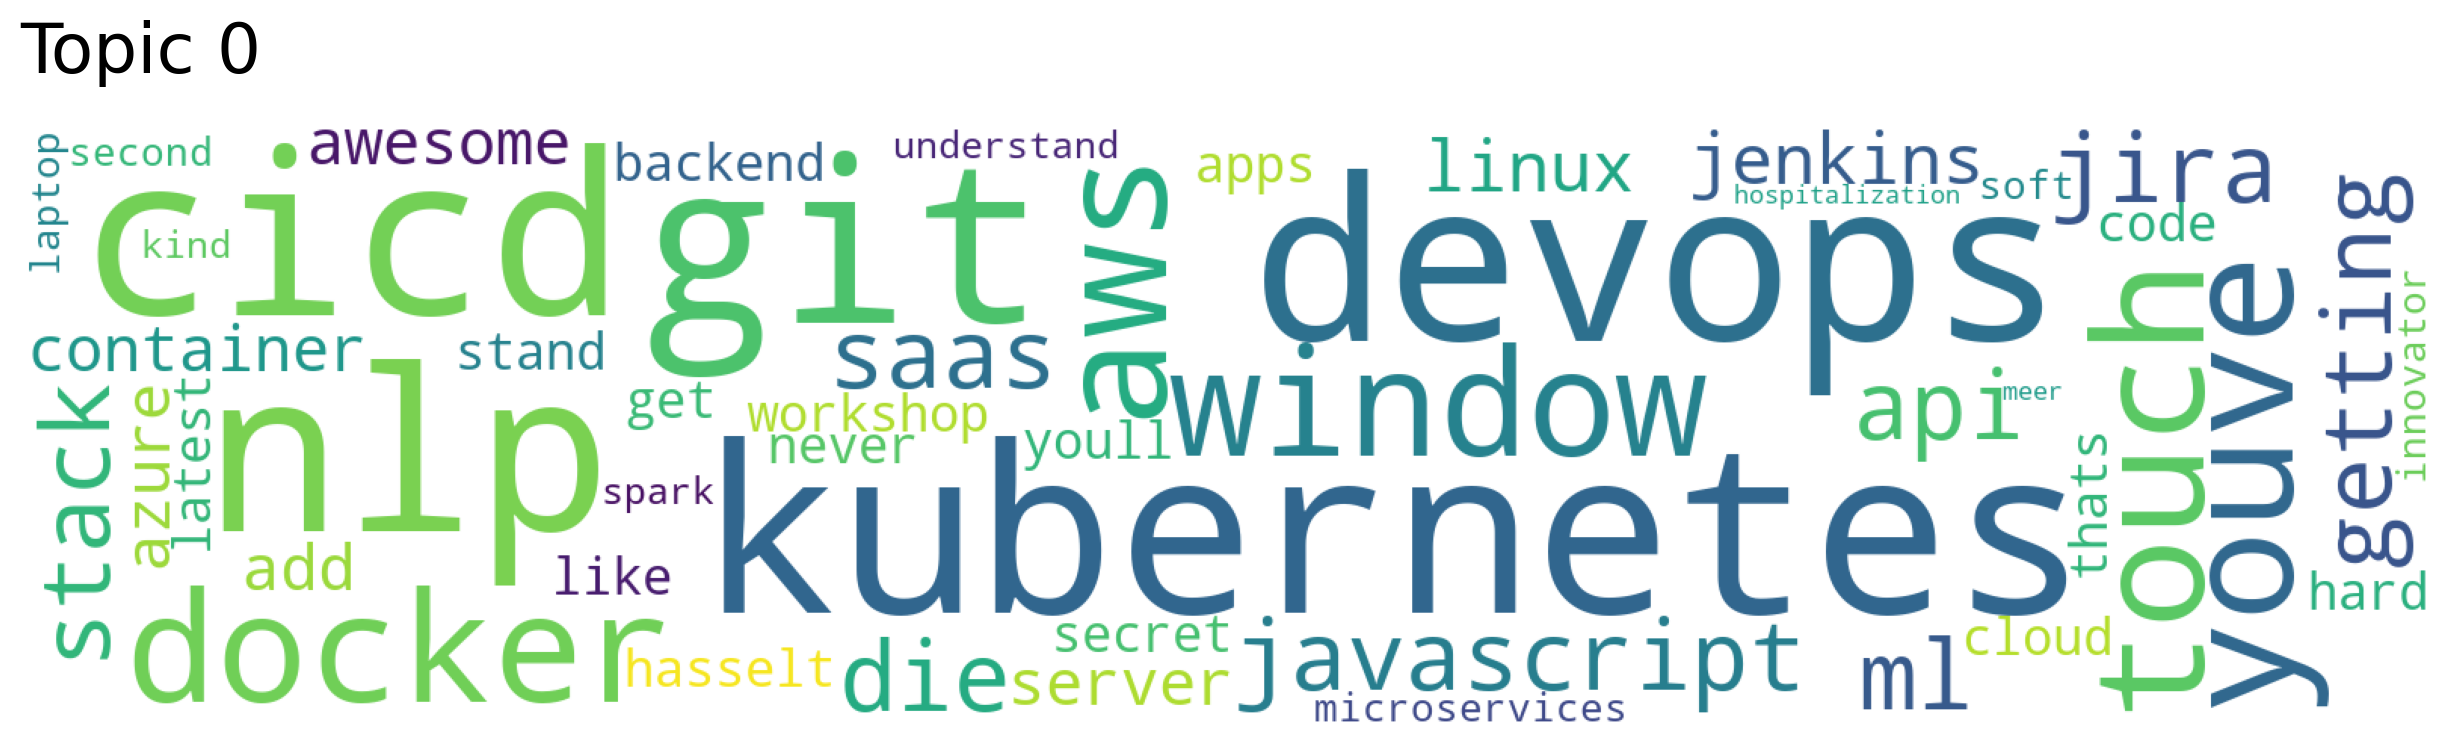

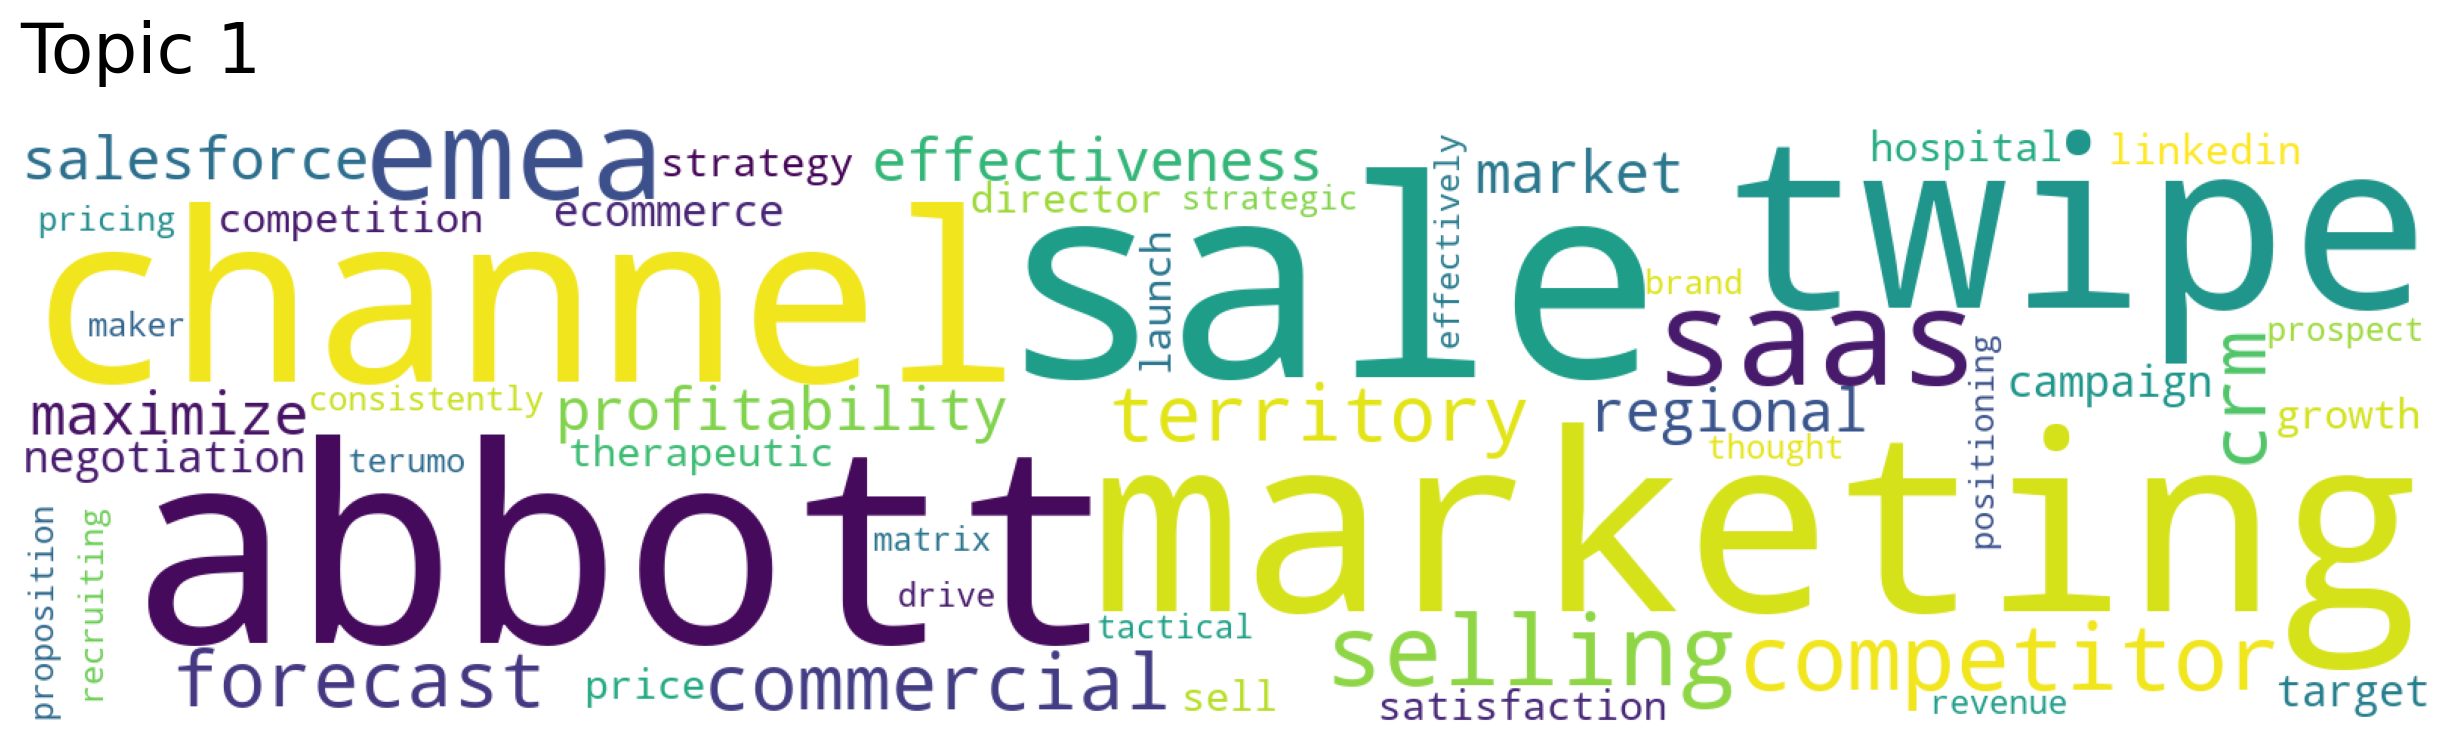

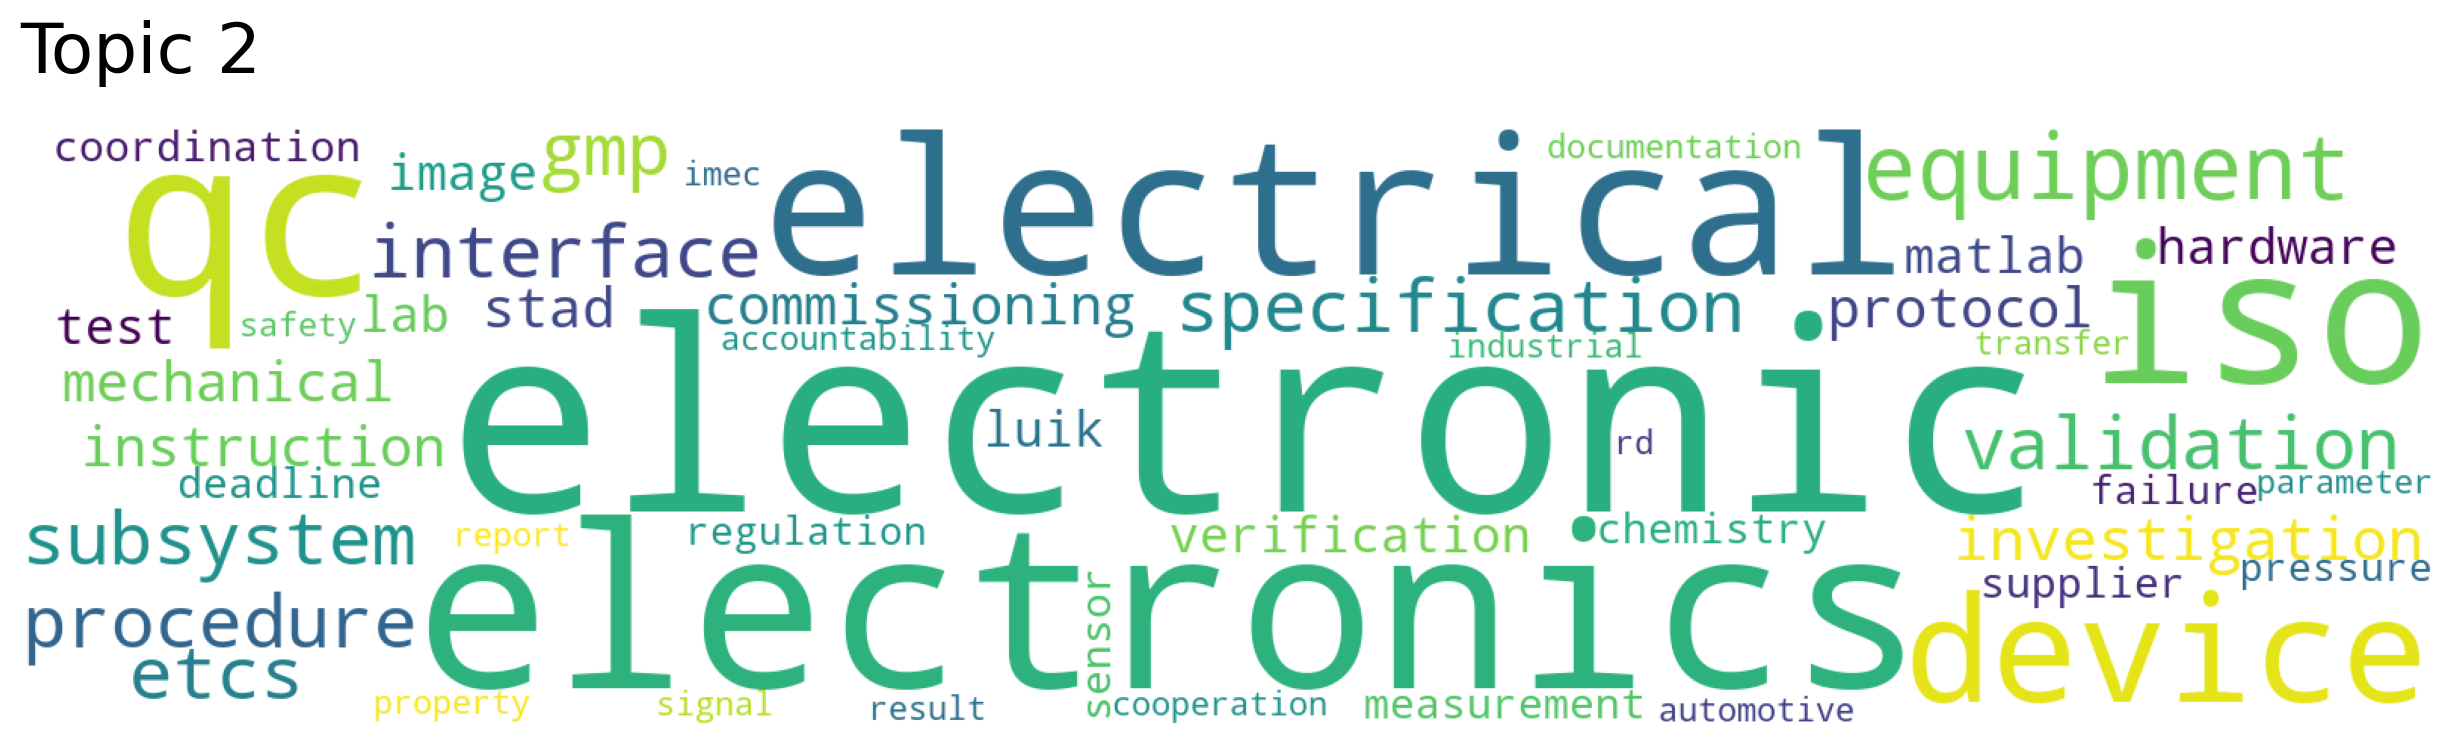

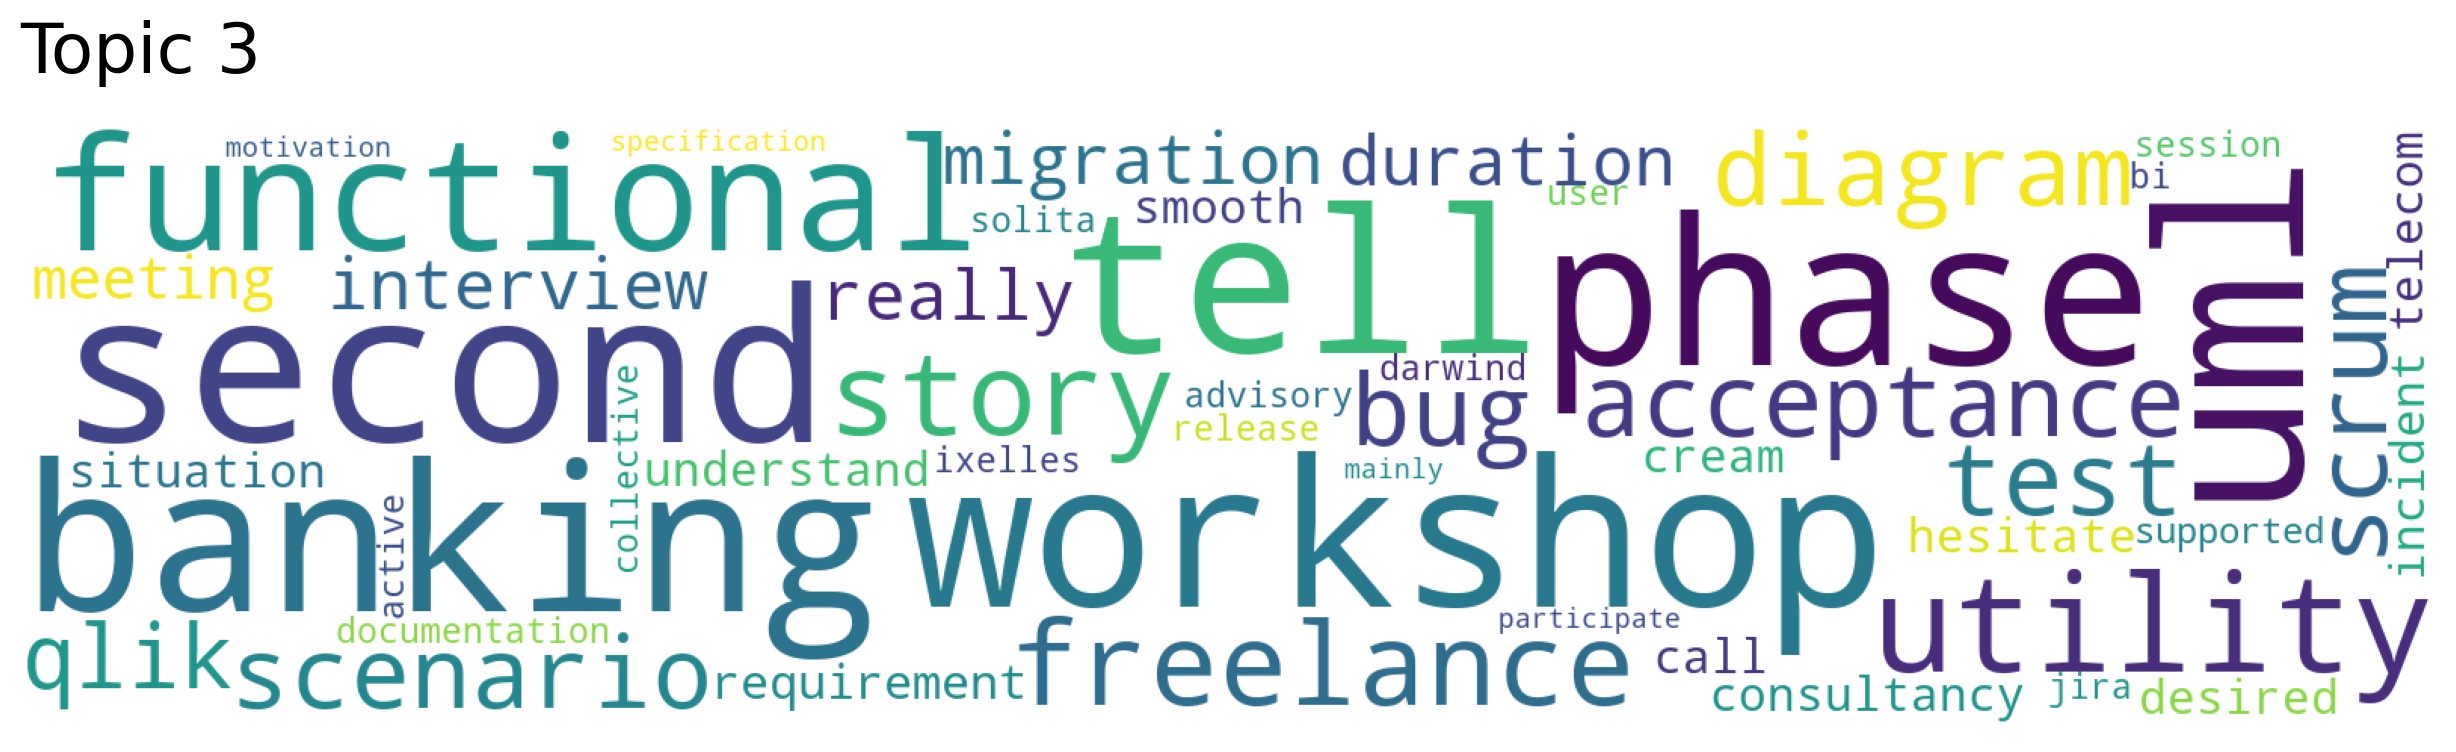

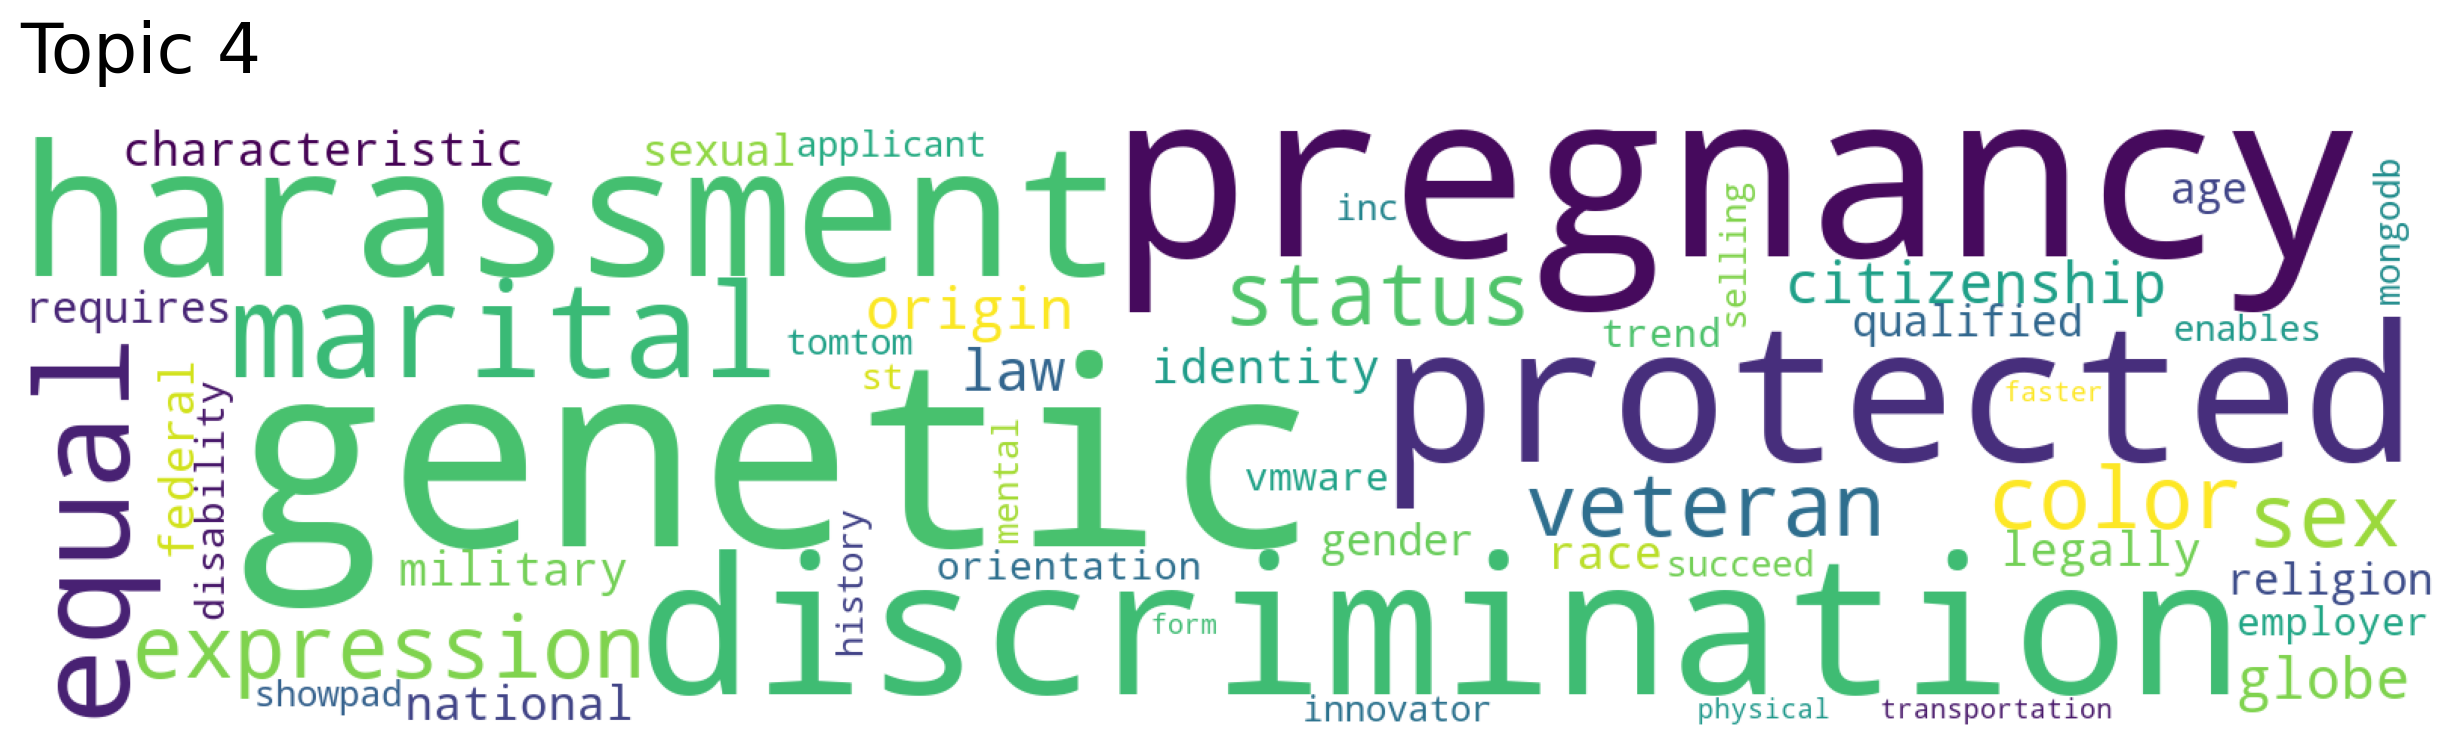

In [ ]:
# display word coulds for the first five topics
topic_words, word_scores, topic_nums = model.get_topics(41)
for topic in topic_nums[0:5]:
    model.generate_topic_wordcloud(topic, background_color="white")

The Top2Vec model allows searching the documents by keywords. The documents are searched for semantically similar content. This is based on cosine similarity scores. We can enter a specific skill or keyword, e.g. Python and find related jobs. A preview of the job description is printed below.

In [ ]:
# use top2vec to get relevant job posting
documents, document_scores, document_ids = model.search_documents_by_keywords(keywords=["Docker", "Matlab", 'python'], num_docs=3)
for doc, score, doc_id in zip(documents, document_scores, document_ids):
    print(f"Document: {doc_id}, Score: {score}")
    print("-----------")
    print(doc)
    print("-----------")
    print()

Document: 2268, Score: 0.4536502957344055
-----------
 senior ml engineer faktion bv antwerpen senior machine learning engineer partly computer scientist partly research engineer analytical mind set deep understanding linear algebra statistic provable handson programming experience part applied ai team passionate machine learning deep learning data science general work interesting project world innovative client partner well work internal technology least year work experience love high growth work environment main objective help customer building integrating machine deep learning model design implement stateoftheart method supervised unsupervised machine learning applied natural language spatial sensor image temporal data design implement stateoftheart enrichment method build data fusion platform able ingest acquire process output different kind data ability understand implement stateoftheart academic research paper help apply novel algorithm large volume reallife data help team improv

# Building Classification Models

We use several algorithms on which our classification models will be based. The list includes: 
* Logistic Regression;
* Random Forest;
* Support vector machines;
* Multinomial Naïve Bayes.

The inputs are the extracted features from the TF-IDF Vectorizer. 
To maximize the prediction power of our models and to pick the best-performing model, we conduct hyperparameter tuning. To tune hyperparameters, we perform a random grid search for each parameter in the models mentioned above. Hence, we want to identify the values of hyperparameters that yield the highest accuracy.

### Data Preparation for Classification

To prepare the data for classification we split the data into train and test set and make use of feature engineering.

To build a classification model, we need to preprocess the job descriptions further. That is, we remove the titles of the job positions from the job descriptions. Otherwise, the categories, like data engineer, data scientist, data analyst, business intelligence, machine learning engineer, might be predicted more effortlessly as the job descriptions contain them. 

In [ ]:
# drop job categories from descriptions
df_english['Cleaned_Text'] = df_english['Cleaned_Text'].replace('data engineer','') # remove 'data engineer'
df_english['Cleaned_Text'] = df_english['Cleaned_Text'].replace('data scientist','') # remove 'data scientist'
df_english['Cleaned_Text'] = df_english['Cleaned_Text'].replace('data analyst','') # remove 'data analyst'
df_english['Cleaned_Text'] = df_english['Cleaned_Text'].replace('business intelligence','') # remove 'business intelligence'
df_english['Cleaned_Text'] = df_english['Cleaned_Text'].replace('machine learning engineer','') # remove 'machine learning engineer'

We need to build our models on training data and
then test and evaluate the performance on test data. Hence, we split our dataset into training and testing data via the train_test_split function from the scikit-learn package. The proportions are 75% of data for the training set and 25% of data for the testing set. 

In [ ]:
# split the data in train and test set
train, test = train_test_split(df_english, test_size=0.25, stratify=df_english['Job_Category'], random_state = 88)

Feature engineering is an essential step in text classification. It helps to create better-performing text classification models. Extracted features work as the inputs for classifiers to identify the textual patterns. In this context, features are unique, measurable attributes for each observation data point in our dataset (Sarkar, 2019). 
Our feature engineering technique is based on the TF-IDF model.
That is, our job descriptions are vectorized with a TF-IDF vectorizer. TF-IDF is beneficial to use as there always might be some words and terms that frequently occur across the descriptions, and they might obscure other words. Specifically, we use the TfidfVectorizer from the Scikit-Learn package.  The underpinnings of the functions are as follows: (1) we directly compute TF-IDF vectors by taking the raw descriptions as inputs, (2) we compute the term frequencies and the inverse document frequencies (Sarkar, 2019). 

In [ ]:
# use the TF-IDF Vectorizer
tf_vector = TfidfVectorizer(ngram_range  = (1,2),
                            stop_words   = 'english',
                            max_df       = .90,
                            min_df       = .10,
                            max_features = None)

# apply TF-IDF to the traning set and print a sample
tf_vector.fit(train['Cleaned_Text'].values)
train_tfidf = tf_vector.transform(train['Cleaned_Text'].values)
train_frame = pd.DataFrame(train_tfidf.toarray(), columns = tf_vector.get_feature_names())
train_frame.sample(5)

ability  ability work      able  ...     youll     young     youre
833   0.000000           0.0  0.262875  ...  0.000000  0.000000  0.000000
1289  0.041129           0.0  0.000000  ...  0.054063  0.000000  0.000000
1591  0.000000           0.0  0.000000  ...  0.053842  0.000000  0.063065
1241  0.060296           0.0  0.000000  ...  0.000000  0.000000  0.000000
1127  0.000000           0.0  0.000000  ...  0.000000  0.173458  0.000000

[5 rows x 576 columns]

In [ ]:
# apply TF-IDF to the test set and print a sample
test_tfidf = tf_vector.transform(test['Cleaned_Text'].values)
test_frame = pd.DataFrame(test_tfidf.toarray(), columns = tf_vector.get_feature_names())
test_frame.sample(5)

ability  ability work      able  ...     youll  young     youre
447  0.000000      0.000000  0.000000  ...  0.000000    0.0  0.000000
273  0.000000      0.000000  0.000000  ...  0.000000    0.0  0.000000
359  0.000000      0.000000  0.000000  ...  0.054608    0.0  0.063962
397  0.000000      0.000000  0.000000  ...  0.000000    0.0  0.050634
93   0.154543      0.063488  0.043244  ...  0.000000    0.0  0.059486

[5 rows x 576 columns]

### Logistic Regression Model

In Scikit-Learn, the function LogisticRegression is used to build a logistic regression model for classification. Our initial and default model parameters are specified as follows. As a solver, we use "liblinear", a linear classifier that performs classification based on the value of a linear combination of feature values. Regarding the technicalities of the solver,  binary classifiers are trained for all classes in a "One-vs-All" manner. The number of iterations is set to 1000. We also balance out the categories by assigning the weights to each category. The "balanced" mode of the "class_weight" parameter uses the values of outcomes to assign weights inversely proportional to class frequencies in the input data (Sklearn.Linear_model.LogisticRegression — Scikit-Learn 0.24.2 Documentation, n.d.).

There are several metrics to assess the performance of our model. We mainly focus on the following metrics: (1) accuracy, (2) precision, (3) recall, (3) F1-score. Accuracy is the overall proportion of correct predictions of the model (Sarkar, 2019). Precision refers to the number of predictions made that are correct out of all the predictions based on the class of interest (Sarkar, 2019). The recall is The F1-score is defined as the weighted average of precision and sensitivity and ranges from 0 to 1 (Sarkar, 2019). The recall metric is the sensitivity which is the fraction of classified true positives. 

We see that overall accuracy for the logistic regression model reaches 0.67, which is indeed satisfactory given the nature of our textual data. We see that the values of individual metrics (precision, sensitivity, F1-score) for categories such as "business intelligence" and "data engineer" range from 0.7 to almost 0.8. 

In [ ]:
lr = LogisticRegression(max_iter=1000, 
                        solver='liblinear', 
                        class_weight='balanced')

lr.fit(train_frame,train['Job_Category'])
prediction = lr.predict(test_frame)
print(classification_report(test['Job_Category'], prediction))


                           precision    recall  f1-score   support

    business intelligence       0.79      0.70      0.74       184
             data analyst       0.57      0.58      0.58        91
            data engineer       0.76      0.77      0.77       181
           data scientist       0.43      0.46      0.45        65
machine learning engineer       0.49      0.60      0.54        55

                 accuracy                           0.67       576
                macro avg       0.61      0.62      0.61       576
             weighted avg       0.68      0.67      0.67       576



We perform a randomized grid search to tune the hyperparameters of our logistic regression model. As hyperparameters, we search a penalty term (L1 or L2 norms) and C-value, which is the inverse of regularization strength and by default equals 1. The number of iterations for the random grid search on the training dataset is 100. We immediately notice that the best accuracy value (0.7180) is achieved using the L1 norm and the default value of C = 1.

In [ ]:
# specify parameters and distributions to sample from
param_dist = {'penalty' : ['l1', 'l2'],
              'C' : [100, 10, 1.0, 0.1, 0.01]}

# run randomized search
n_iter_search = 100
random_search = RandomizedSearchCV(lr, param_distributions=param_dist,
                                   n_iter=n_iter_search,
                                   scoring='accuracy',
                                   error_score=0)

grid_result = random_search.fit(train_frame,train['Job_Category'])

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 10 is smaller than n_iter=100. Running 10 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Best: 0.718015 using {'penalty': 'l1', 'C': 1.0}
0.615513 (0.006971) with: {'penalty': 'l1', 'C': 100}
0.631725 (0.012506) with: {'penalty': 'l2', 'C': 100}
0.656046 (0.010425) with: {'penalty': 'l1', 'C': 10}
0.680365 (0.006989) with: {'penalty': 'l2', 'C': 10}
0.718015 (0.019691) with: {'penalty': 'l1', 'C': 1.0}
0.703517 (0.024579) with: {'penalty': 'l2', 'C': 1.0}
0.644475 (0.006921) with: {'penalty': 'l1', 'C': 0.1}
0.669349 (0.035983) with: {'penalty': 'l2', 'C': 0.1}
0.319050 (0.000949) with: {'penalty': 'l1', 'C': 0.01}
0.601612 (0.009293) with: {'penalty': 'l2', 'C': 0.01}


Next, we apply the fine-tuned logistic regression model to our test data. We see that the accuracy value increased by 0.03 and now equals 0.70. Individual metrics precision, recall, F1-score for categories noticeably improved as well.

In [ ]:
lr1 = LogisticRegression(max_iter=1000, 
                        solver='liblinear', 
                        class_weight='balanced',
                        penalty = "l1",
                        C = 1.0 )

lr1.fit(train_frame,train['Job_Category'])
prediction = lr1.predict(test_frame)
print(classification_report(test['Job_Category'], prediction))

                           precision    recall  f1-score   support

    business intelligence       0.80      0.77      0.78       184
             data analyst       0.58      0.59      0.59        91
            data engineer       0.82      0.77      0.79       181
           data scientist       0.49      0.55      0.52        65
machine learning engineer       0.52      0.60      0.55        55

                 accuracy                           0.70       576
                macro avg       0.64      0.66      0.65       576
             weighted avg       0.71      0.70      0.70       576



###  Random Forest Model

A random forest is an ensemble model. The algorithm runs in parallel and fits a specified number of decision tree classifiers on training dataset sub-samples (Sarkar, 2019). It improves accuracy and controls potential overfitting by averaging (Sarkar, 2019). Each tree is fitted to the bootstrap sub-samples drawn from the training set (Sarkar, 2019). In Scikit-Learn, the function RandomForestClassifier is used to build a random forest for classification. Our initial and default model parameters are specified as follows. The number of trees in the forest is 100, the maximum depth of the tree is 15. We see that overall accuracy for the random forest model reaches 0.64, which is indeed satisfactory but still less than the accuracy value of the logistic regression model. We see that the values of individual metrics (precision, sensitivity, F1-score) for categories such as "business intelligence" and "data engineer" range from 0.7 to 0.79.

In [ ]:
clf = RandomForestClassifier(n_estimators=100, 
                             max_depth=15)

clf.fit(train_frame,train['Job_Category'])
prediction = clf.predict(test_frame)
print(classification_report(test['Job_Category'], prediction))

                           precision    recall  f1-score   support

    business intelligence       0.79      0.79      0.79       184
             data analyst       0.51      0.44      0.47        91
            data engineer       0.70      0.77      0.73       181
           data scientist       0.40      0.38      0.39        65
machine learning engineer       0.42      0.38      0.40        55

                 accuracy                           0.64       576
                macro avg       0.56      0.55      0.56       576
             weighted avg       0.64      0.64      0.64       576



The number of iterations for the random grid search on the training dataset is 100. The hyperparameters that we want to tune are the number of trees in the forest (from 200 to 2000), the number of features ('auto', 'sqrt'), the maximum depth of the tree (from 10 to 110), the minimum number of samples required to split an internal node (2, 5, 10), the minimum number of samples required to be at a leaf node (1, 2, 4), the use of bootstrap samples (Sklearn.Ensemble.RandomForestClassifier — Scikit-Learn 0.24.2 Documentation, n.d.).

We see that the best accuracy value is 0.7046 using 200 trees, 5 samples to split an internal node, 4 samples to be at a leaf node, 10 is the maximum depth of the tree and bootstrap is enabled.

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_random = RandomizedSearchCV(estimator = clf, 
                               param_distributions = random_grid, 
                               n_iter = 100, 
                               cv = 3, 
                               verbose=2, 
                               random_state=42, 
                               n_jobs = -1)

grid_result1 = rf_random.fit(train_frame,train['Job_Category'])

In [ ]:
print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.704689 using {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 10, 'bootstrap': True}
0.695426 (0.014885) with: {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': True}
0.691958 (0.014209) with: {'n_estimators': 2000, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True}
0.698326 (0.012576) with: {'n_estimators': 1200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': False}
0.699481 (0.010166) with: {'n_estimators': 2000, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 30, 'bootstrap': False}
0.704117 (0.016686) with: {'n_estimators': 1600, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True}
0.700059 (0.013587) with: {'n_estimators': 800, 'min_samples_split': 

Next, we apply the fine-tuned random forest model to our test data. We see that the accuracy value increased by 0.02 and now equals 0.66. Individual metrics precision, recall, F1-score for categories improved. However, the accuracy is still greater for the logistic regression model.

In [ ]:
clf1 = RandomForestClassifier(n_estimators=200, 
                             min_samples_split = 5, 
                             min_samples_leaf = 4,
                             max_features = "auto",
                             max_depth=10,
                             bootstrap = True)
clf1.fit(train_frame,train['Job_Category'])
prediction = clf1.predict(test_frame)
print(classification_report(test['Job_Category'], prediction))

                           precision    recall  f1-score   support

    business intelligence       0.77      0.82      0.80       184
             data analyst       0.56      0.47      0.51        91
            data engineer       0.70      0.83      0.76       181
           data scientist       0.35      0.29      0.32        65
machine learning engineer       0.43      0.27      0.33        55

                 accuracy                           0.66       576
                macro avg       0.56      0.54      0.54       576
             weighted avg       0.64      0.66      0.64       576



### Support Vector Machines Model

Another method that we use for our job categories classification is Support Vector Machines, or simply SVM. SVM works as follows. First, it takes the features as inputs and constructs a hyperplane for a high-dimensional feature space (Sarkar, 2019). We want the wider margins of this hyperplane as it achieves a better separation between classes. For a detailed description of the methods, an interested reader may be referred to Sarkar (2019). In Scikit-Learn, the function SVC is used to build an SVM for the classification problem. Since our classification problem is multinomial, for each category, a binary SVM classifier is fitted.

We use the default parameter settings for our SVM model. The overall accuracy value for the SVM model is 0.64. We see that the values of individual metrics (precision, sensitivity, F1-score) for categories such as "business intelligence" and "data engineer" range from 0.74 to 0.79. For other categories, the values of metrics are comparable with the results yielded by the logistic regression and random forest models.



In [ ]:
svc_classifier = SVC()
svc_classifier.fit(train_frame,train['Job_Category'])
prediction = svc_classifier.predict(test_frame)
print(classification_report(test['Job_Category'], prediction))

                           precision    recall  f1-score   support

    business intelligence       0.74      0.75      0.74       184
             data analyst       0.49      0.42      0.45        91
            data engineer       0.74      0.79      0.76       181
           data scientist       0.39      0.40      0.39        65
machine learning engineer       0.49      0.45      0.47        55

                 accuracy                           0.64       576
                macro avg       0.57      0.56      0.56       576
             weighted avg       0.64      0.64      0.64       576



The number of iterations for the random grid search on the training dataset is 100. The hyperparameters that we want to tune are the kernel type to be used in the algorithm (the radial basis function kernel, or RBF, and linear function),  kernel coefficient gamma (uniformly sampled values from 1e-4 to 1e-3), regularization parameter C (uniformly sampled values from 1e+0 to 1e+3).

We see that the best accuracy value is 0.7000. The fine-tuned parameter values are C = 890.6204, gamma = 0.0003 with the radial basis function kernel.

In [ ]:
parameters = [{'kernel': ['rbf'], 
                     'gamma': loguniform(1e-4, 1e-3),
                     'C': loguniform(1e0, 1e3)},
                    {'kernel': ['linear'], 
                     'C': loguniform(1e0, 1e3)}]

svm_random = RandomizedSearchCV(estimator = svc_classifier, 
                               param_distributions = parameters, 
                               n_iter = 100, 
                               cv = 3, 
                               verbose=2, 
                               random_state=42, 
                               n_jobs = -1)

grid_result2 = svm_random.fit(train_frame,train['Job_Category'])

print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
means = grid_result2.cv_results_['mean_test_score']
stds = grid_result2.cv_results_['std_test_score']
params = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))



Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.7min finished


Best: 0.700044 using {'C': 890.620438616168, 'gamma': 0.0002929293535977796, 'kernel': 'rbf'}
0.584821 (0.018618) with: {'C': 245.2612631133676, 'gamma': 0.00015255793090045733, 'kernel': 'rbf'}
0.636362 (0.010887) with: {'C': 62.51373574521747, 'kernel': 'linear'}
0.319050 (0.000558) with: {'C': 21.751953118777642, 'gamma': 0.00012588527002965473, 'kernel': 'rbf'}
0.688461 (0.019829) with: {'C': 396.76050770529866, 'gamma': 0.00039913058785616786, 'kernel': 'rbf'}
0.632309 (0.012904) with: {'C': 89.67376801947961, 'kernel': 'linear'}
0.697732 (0.011331) with: {'C': 812.3245085588684, 'gamma': 0.0006798962421591127, 'kernel': 'rbf'}
0.695417 (0.010993) with: {'C': 1.0053940194693016, 'kernel': 'linear'}
0.670522 (0.009597) with: {'C': 3.5498788321965016, 'kernel': 'linear'}
0.635783 (0.012904) with: {'C': 68.38478430964042, 'kernel': 'linear'}
0.319050 (0.000558) with: {'C': 19.762189340280067, 'gamma': 0.00019553708662745247, 'kernel': 'rbf'}
0.319050 (0.000558) with: {'C': 15.8337183

Next, we apply the fine-tuned SVM model to our test data. We see that the accuracy value increased by 0.03 and now equals 0.67. Individual metrics precision, recall, F1-score for categories improved. However, the accuracy is still greater for the logistic regression model.

In [ ]:
svc_classifier1 = SVC(C = 890.620438616168, 
                      gamma = 0.0002929293535977796, 
                      kernel =  'rbf')
svc_classifier1.fit(train_frame,train['Job_Category'])
prediction = svc_classifier1.predict(test_frame)
print(classification_report(test['Job_Category'], prediction))

                           precision    recall  f1-score   support

    business intelligence       0.73      0.78      0.75       184
             data analyst       0.57      0.56      0.57        91
            data engineer       0.72      0.80      0.76       181
           data scientist       0.48      0.40      0.44        65
machine learning engineer       0.54      0.36      0.43        55

                 accuracy                           0.67       576
                macro avg       0.61      0.58      0.59       576
             weighted avg       0.66      0.67      0.66       576



### Multinomial Naïve Bayes Model

Multinomial Naïve Bayes model is a special case of the Naïve Bayes algorithm (Sarkar, 2019). It is used for classification purposes where the outcome variable contains more than two classes (Sarkar, 2019). As it is deeply rooted in Bayesian statistics, we assume that each textual feature is conditionally independent of other textual feature (Sarkar, 2019).  In Scikit-Learn, the function MultinomialNB implements Multinomial Naïve Bayes model for classification.  Once we ran our model, we notice that overall accuracy for the Multinomial Naïve Bayes model reaches 0.64. We see that the values of individual metrics (precision, F1-score) for categories are smaller than for the other above-described models. However, the categories "data engineer" and "business intelligence" score high on the recall metric (0.83 and 0.80, respectively).

In [ ]:
naive = MultinomialNB()
naive.fit(train_frame,train['Job_Category'])
prediction = naive.predict(test_frame)
print(classification_report(test['Job_Category'], prediction))

                           precision    recall  f1-score   support

    business intelligence       0.64      0.80      0.71       184
             data analyst       0.56      0.33      0.41        91
            data engineer       0.68      0.83      0.75       181
           data scientist       0.57      0.35      0.44        65
machine learning engineer       0.61      0.36      0.45        55

                 accuracy                           0.64       576
                macro avg       0.61      0.53      0.55       576
             weighted avg       0.63      0.64      0.62       576



The number of iterations for the random grid search on the training dataset is 100. The hyperparameters that we want to tune are additive smoothing parameter "alpha". This parameter is useful as it may correct for the features that are absent in the test data (Sarkar, 2019). Given that, it helps to reduce the zero probability related problems (Sarkar, 2019). In Sarkar (2019), it is stated that the value of alpha = 1 is named as Laplace smoothing, and the value of alpha < 1 is named as Lidstone smoothing. The "fit_prior'' hyperparameter is set to either True or False. 

In [ ]:
parameters_nb =  {
  'alpha': np.linspace(0.00001, 20, 10),
  'fit_prior': [True, False],  
}

nb_random = RandomizedSearchCV(estimator = naive, 
                               param_distributions = parameters_nb, 
                               n_iter = 100, 
                               cv = 3, 
                               verbose=2, 
                               random_state=42, 
                               n_jobs = -1)

grid_result3 = nb_random.fit(train_frame,train['Job_Category'])

print("Best: %f using %s" % (grid_result3.best_score_, grid_result3.best_params_))
means = grid_result3.cv_results_['mean_test_score']
stds = grid_result3.cv_results_['std_test_score']
params = grid_result3.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 20 is smaller than n_iter=100. Running 20 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best: 0.672242 using {'fit_prior': False, 'alpha': 4.444452222222222}
0.646772 (0.017218) with: {'fit_prior': True, 'alpha': 1e-05}
0.639237 (0.027115) with: {'fit_prior': False, 'alpha': 1e-05}
0.621881 (0.010305) with: {'fit_prior': True, 'alpha': 2.2222311111111113}
0.669351 (0.021995) with: {'fit_prior': False, 'alpha': 2.2222311111111113}
0.594666 (0.013082) with: {'fit_prior': True, 'alpha': 4.444452222222222}
0.672242 (0.026827) with: {'fit_prior': False, 'alpha': 4.444452222222222}
0.577867 (0.021161) with: {'fit_prior': True, 'alpha': 6.666673333333334}
0.667035 (0.021991) with: {'fit_prior': False, 'alpha': 6.666673333333334}
0.567450 (0.013271) with: {'fit_prior': True, 'alpha': 8.888894444444444}
0.649664 (0.022005) with: {'fit_prior': False, 'alpha': 8.888894444444444}
0.560500 (0.014675) with: {'fit_prior': True, 'alpha': 11.111115555555555}
0.649668 (0.017612) with: {'fit_prior': False, 'alpha': 11.111115555555

[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.6s finished


We see that the best accuracy value is 0.672242. The fine-tuned parameter values are alpha = 4.4444. Given that alpha < 1, we employ Lidstone smoothing. The mode "False" for the "fit_prior" hyperparameter corresponds to the uniform prior (Sklearn.Naive_bayes.MultinomialNB — Scikit-Learn 0.24.2 Documentation, n.d.).
Next, we apply the fine-tuned Multinomial Naïve Bayes model to our test data. We see that the accuracy value increased by 0.02 and now equals 0.66. Individual metrics precision, recall, F1-score for categories also improved. However, the accuracy is still greater for the logistic regression model.

In [ ]:
naive1 = MultinomialNB(fit_prior = False, alpha = 4.444452222222222)
naive1.fit(train_frame,train['Job_Category'])
prediction = naive1.predict(test_frame)
print(classification_report(test['Job_Category'], prediction))

                           precision    recall  f1-score   support

    business intelligence       0.75      0.71      0.73       184
             data analyst       0.59      0.53      0.55        91
            data engineer       0.73      0.77      0.75       181
           data scientist       0.52      0.52      0.52        65
machine learning engineer       0.50      0.56      0.53        55

                 accuracy                           0.66       576
                macro avg       0.62      0.62      0.62       576
             weighted avg       0.67      0.66      0.66       576



# Conclusion

Scraping and analyzing data from *Indeed.com* was challenging and provided us with interesting insights into the Belgian job market for data-related jobs. The scraping was time-consuming as we had to send requests twice: for gathering the links to job posting and afterwords getting the job description text from the links. The BeautifulSoup package was usable to extract the data from the requests. The "sleep" function was necessary not to overwhelm the server and a fake-user agent not to get banned. We applied data cleaning techniques to prepare the job descriptions for our analysis.

We saw that the data engineer and business intelligence search returned the most search results. Job descriptions in the English language were most common. The word-frequency distributions provided an insight into popular catchwords and phrases, which we can include in our CV and cover letters.

Python was often mentioned and seemed to be a valuable skill in our job search for skills. However, as we have seen, the different data-related job may require additional programming skills and proficiency in multiple programming skills. The topic modelling with LDA gave insights into underlying job descriptions, e.g. consulting, supply chain or research-focused. The classification model with the obtained LDA topics was somewhat inadequate. The Top2Vec model was more helpful in this respect and found 41 underlying topics in our job descriptions. Inspecting some of the topics with word clouds was fascinating as the model identified, e.g. a topic related to workplace discrimination. Top2Vec allowed the semantic search, which we used to search jobs that match a specific keyword, such as a skill set we possess.

Lastly, we build classification models to see if the job description text is predictive for the search term the job appeared under. We used the TF-IDF Vectorizer to prepare the text. The logistic regression model with tuned hyperparameters provided the best results with an overall accuracy of 70% on the test set. We were surprised by the high accuracy the models returned because the search terms and their related job titles are somewhat fluid, making it hard to predict which category they fall in. The models proved us differently as the job description is reasonably predictive for the search term a job appears under.

However, we acknowledge that our approach can be improved. For example, we might continue the modelling with deep learning techniques. Another research possibility is to conduct a cross-country comparison for data-related jobs using our approach. 

With this project, we sharpened our Python skills. We are glad that we had the chance to work on a project of personal relevance for our professional career. The notebook can be used for other jobs categories in different countries and applied to different skill sets. We are eager to use the gained insights in our job hunt and share our insights with people in need. 

# References

Halwani, M. A., Amirkiaee, S. Y., Evangelopoulos, N., & Prybutok, V. (2021). Job qualifications study for data science and big data professions. *Information Technology & People.* https://doi.org/10.1108/itp-04-2020-0201

Hovy, D. (2021). *Text Analysis in Python for Social Scientists: Discovery and Exploration (Elements in Quantitative and Computational Methods for the Social Sciences).* Cambridge University Press.

*No Work Experience? Here’s How To Overcome The Permission Paradox And Get Hired.* (2019, December 20). Grasp Psychometrics, Leadership, & Recruiting in Our HR Blog. https://good.co/blog/how-to-overcome-the-permission-paradox/

Sarkar, D. (2019).*Text Analytics with Python: A Practitioner’s Guide to Natural Language Processing (2nd ed.).* Apress.

*sklearn.ensemble.RandomForestClassifier — scikit-learn 0.24.2 documentation.* (n.d.). Scikit-Learn: Machine Learning in Python. Retrieved June 4, 2021, from https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

*sklearn.linear_model.LogisticRegression — scikit-learn 0.24.2 documentation. (n.d.).* Scikit-Learn: Machine Learning in Python. Retrieved June 4, 2021, from https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

*sklearn.naive_bayes.MultinomialNB — scikit-learn 0.24.2 documentation. (n.d.).* Scikit-Learn: Machine Learning in Python. Retrieved June 4, 2021, from https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
